In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.problems.functional import FunctionalProblem

from tqdm import tqdm


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay


from utils import plot_proba

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, Optional

# check if torch.cuda is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




Using device: cuda


In [2]:
# load minist dataset
from torchvision import datasets, transforms

# Image size configuration - using 16x16 to reduce search space (256 vs 784 dimensions)
IMG_SIZE = 16

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize from 28x28 to 16x16
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

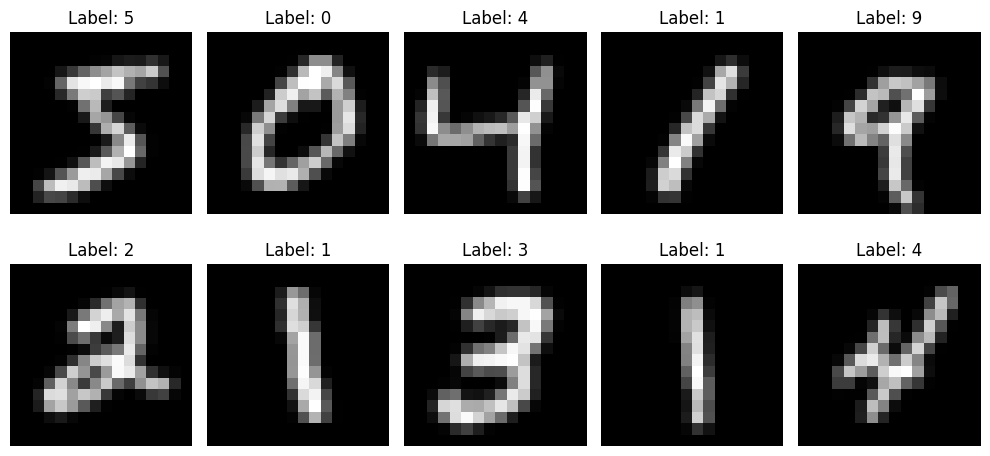

MNIST Train dataset size: 60000
MNIST Test dataset size: 10000
Image shape: torch.Size([1, 16, 16])


In [3]:
# Visualize some images from the MNIST dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(train_dataset[i][0].squeeze(), cmap='gray')
    ax.set_title(f"Label: {train_dataset[i][1]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f"MNIST Train dataset size: {len(train_dataset)}")
print(f"MNIST Test dataset size: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

Setting up MNIST probability function...
Dataset size: 60000 images

Test indices: [0.  0.5 1. ]
Corresponding dataset indices: [0, 30000, 59999]
True labels: [np.int64(5), np.int64(3), np.int64(8)]
Probability shapes: (3, 10)


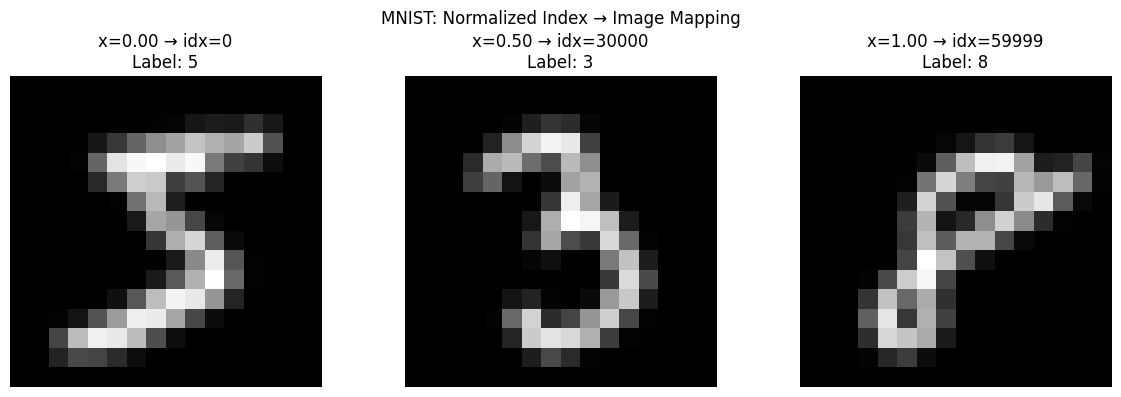

In [4]:
# ============================================================================
# MNIST-based Probability Function for Counterfactual Generation
# ============================================================================
# 
# Concept: Map a 1D normalized index x ∈ [0, 1] to:
#   1. An MNIST image (via index into the dataset)
#   2. A 10-class probability distribution P(Y|X)
#
# The "feature space" X is 1D: the normalized position in the dataset
# The "label space" Y is the digit class {0, 1, ..., 9}
# 
# For counterfactual generation:
#   - x* is a factual instance (normalized index of an image)
#   - We search for x̄ (counterfactual) where the model predicts a different class
#   - x̄ corresponds to a different image in the dataset
# ============================================================================

class MNISTProbabilityFunction:
    """
    A probability function for MNIST that maps normalized indices to class probabilities.
    
    This creates a bridge between:
    - 1D latent space X ∈ [0, 1] (normalized dataset index)
    - 10-class probability distribution P(Y|X)
    - The actual MNIST images
    """
    
    def __init__(self, dataset, model=None, use_true_labels=True, temperature=1.0):
        """
        Args:
            dataset: MNIST dataset (torchvision)
            model: Optional trained classifier. If provided, uses model predictions.
                   If None, uses one-hot encoding of true labels.
            use_true_labels: If True and no model, use ground truth labels
            temperature: Softmax temperature for smoothing probabilities
        """
        self.dataset = dataset
        self.n_samples = len(dataset)
        self.n_classes = 10
        self.model = model
        self.use_true_labels = use_true_labels
        self.temperature = temperature
        self.device = next(model.parameters()).device if model else "cpu"
        
        # Pre-compute labels for fast lookup
        self._labels = np.array([dataset[i][1] for i in range(self.n_samples)])
        
        # Cache for images (lazy loading)
        self._image_cache = {}
    
    def index_to_normalized(self, idx: int) -> float:
        """Convert dataset index to normalized value in [0, 1]."""
        return idx / (self.n_samples - 1)
    
    def normalized_to_index(self, x: float) -> int:
        """Convert normalized value to dataset index."""
        x = np.clip(x, 0.0, 1.0)
        return int(np.round(x * (self.n_samples - 1)))
    
    def get_image(self, x: float) -> torch.Tensor:
        """Get the MNIST image corresponding to normalized index x."""
        idx = self.normalized_to_index(x)
        if idx not in self._image_cache:
            self._image_cache[idx] = self.dataset[idx][0]
        return self._image_cache[idx]
    
    def get_label(self, x: float) -> int:
        """Get the true label for normalized index x."""
        idx = self.normalized_to_index(x)
        return self._labels[idx]
    
    def __call__(self, X: np.ndarray) -> np.ndarray:
        """
        Compute P(Y|X) for normalized indices X.
        
        Args:
            X: Array of normalized indices, shape (n,) or (n, 1)
            
        Returns:
            probs: Probability distribution over 10 classes, shape (n, 10)
        """
        X = np.asarray(X).flatten()
        n = len(X)
        probs = np.zeros((n, self.n_classes))
        
        if self.model is not None:
            # Use model predictions
            self.model.eval()
            for i, x in enumerate(X):
                img = self.get_image(x).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    logits = self.model(img)
                    p = nn.Softmax(dim=1)(logits / self.temperature).cpu().numpy()
                probs[i] = p[0]
        else:
            # Use true labels with one-hot encoding (with small smoothing)
            epsilon = 0.01  # label smoothing
            for i, x in enumerate(X):
                label = self.get_label(x)
                probs[i] = epsilon / self.n_classes
                probs[i, label] = 1.0 - epsilon + epsilon / self.n_classes
        
        return probs
    
    def get_images_batch(self, X: np.ndarray) -> torch.Tensor:
        """Get batch of images for normalized indices."""
        X = np.asarray(X).flatten()
        images = torch.stack([self.get_image(x) for x in X])
        return images


# ============================================================================
# MNIST Classifier Model (CNN)
# ============================================================================

class MNISTClassifier(nn.Module):
    """Lightweight CNN classifier for MNIST with 2 convolutional layers.
    
    Supports configurable input size (default 16x16 for reduced search space).
    """
    
    def __init__(self, img_size=16):
        super().__init__()
        self.img_size = img_size
        
        # After 2 pooling layers: img_size -> img_size/2 -> img_size/4
        final_size = img_size // 4  # 16 -> 4, 28 -> 7
        
        self.conv = nn.Sequential(
            # Conv layer 1: 1 -> 16 channels, img_size -> img_size/2 after pooling
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            # Conv layer 2: 16 -> 32 channels, img_size/2 -> img_size/4 after pooling
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * final_size * final_size, 64), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        return self.conv(x)


# ============================================================================
# Data Generating Process for MNIST
# ============================================================================

def mnist_dpg(
    n: int,
    mnist_prob_fn: MNISTProbabilityFunction,
    rng: Optional[np.random.Generator] = None,
    sample_mode: str = "uniform",  # "uniform" or "sequential"
    return_images: bool = False  # if True, also return actual images
) -> Tuple[np.ndarray, np.ndarray, np.ndarray] | Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Data Generating Process for MNIST using normalized indices.
    
    Args:
        n: Number of samples
        mnist_prob_fn: MNISTProbabilityFunction instance
        rng: Random number generator
        sample_mode: "uniform" samples random indices, "sequential" uses first n
        return_images: If True, also return actual images for training
        
    Returns:
        X: Normalized indices, shape (n, 1)
        Y: Class labels (true labels from dataset), shape (n,)
        probs: Probability distributions, shape (n, 10)
        images (optional): Actual images, shape (n, 1, 28, 28) if return_images=True
    """
    rng = np.random.default_rng() if rng is None else rng
    
    if sample_mode == "uniform":
        # Random sampling of indices
        indices = rng.choice(mnist_prob_fn.n_samples, size=n, replace=False)
        X = np.array([mnist_prob_fn.index_to_normalized(i) for i in indices])
    else:
        # Sequential sampling
        indices = np.linspace(0, mnist_prob_fn.n_samples - 1, n, dtype=int)
        X = np.linspace(0, 1, n)
    
    X = X.reshape(-1, 1)  # Shape (n, 1)
    
    # Get true labels from dataset
    Y = np.array([mnist_prob_fn._labels[i] for i in indices], dtype=np.int64)
    
    # Get probability distributions (if model is available)
    probs = mnist_prob_fn(X)
    
    # Normalize probabilities to ensure they sum to 1 (fix floating-point issues)
    probs = np.clip(probs, 0.0, 1.0)
    probs = probs / probs.sum(axis=-1, keepdims=True)
    
    if return_images:
        # Get actual images for training
        images = np.array([mnist_prob_fn.dataset[i][0].numpy() for i in indices])
        return X, Y, probs, images
    
    return X, Y, probs


# ============================================================================
# Demo: Setup MNIST probability function
# ============================================================================

print("Setting up MNIST probability function...")
print(f"Dataset size: {len(train_dataset)} images")

# Create probability function using true labels (no model yet)
mnist_p_fn = MNISTProbabilityFunction(train_dataset, model=None, use_true_labels=True)

# Test the probability function
test_indices = np.array([0.0, 0.5, 1.0])
test_probs = mnist_p_fn(test_indices)
print(f"\nTest indices: {test_indices}")
print(f"Corresponding dataset indices: {[mnist_p_fn.normalized_to_index(x) for x in test_indices]}")
print(f"True labels: {[mnist_p_fn.get_label(x) for x in test_indices]}")
print(f"Probability shapes: {test_probs.shape}")

# Visualize the mapping
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, x in enumerate(test_indices):
    img = mnist_p_fn.get_image(x).squeeze()
    label = mnist_p_fn.get_label(x)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"x={x:.2f} → idx={mnist_p_fn.normalized_to_index(x)}\nLabel: {label}")
    axes[i].axis('off')
plt.suptitle("MNIST: Normalized Index → Image Mapping")
plt.tight_layout()
plt.show()

In [5]:
# ============================================================================
# Train MNIST Classifier ENSEMBLE (Deep Ensemble for Uncertainty)
# ============================================================================
# Deep Ensemble: Train multiple models with:
#   1. Different random initializations
#   2. Different random data samples (bootstrapping)
# This gives us proper epistemic uncertainty estimation

n_train_samples = 5000  # Number of samples per model

# ============================================================================
# ENSEMBLE TRAINING with DIFFERENT DATA SAMPLES
# ============================================================================
N_ENSEMBLE = 5  # Number of models in ensemble (typically 5-10)
num_epochs_mnist = 5  # MNIST converges quickly

ensemble_models = []
mnist_test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"{'='*60}")
print(f"Training Deep Ensemble with {N_ENSEMBLE} models")
print(f"Each model trained on DIFFERENT random sample of {n_train_samples} images")
print(f"{'='*60}")

for model_idx in range(N_ENSEMBLE):
    print(f"\n--- Training Model {model_idx + 1}/{N_ENSEMBLE} ---")
    
    # =========== RESAMPLE DATA with DIFFERENT SEED for each model ===========
    data_seed = 42 + model_idx * 123  # Different seed for each model's data
    print(f"  Data sampling seed: {data_seed}")
    
    X_idx, Y_sampled, probs_sampled, images_sampled = mnist_dpg(
        n=n_train_samples,
        mnist_prob_fn=mnist_p_fn,
        rng=np.random.default_rng(data_seed),  # Different random sample!
        sample_mode="uniform",
        return_images=True
    )
    
    # Create TensorDataset from this model's sampled data
    sampled_train_dataset = TensorDataset(
        torch.tensor(images_sampled, dtype=torch.float32),
        torch.tensor(Y_sampled, dtype=torch.long)
    )
    mnist_train_loader = DataLoader(sampled_train_dataset, batch_size=64, shuffle=True)
    
    # =========== INITIALIZE MODEL with DIFFERENT SEED ===========
    model_seed = 1000 + model_idx * 1000  # Different initialization
    torch.manual_seed(model_seed)
    print(f"  Model init seed: {model_seed}")
    
    model = MNISTClassifier(img_size=IMG_SIZE).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Training loop
    bar = tqdm(range(num_epochs_mnist), desc=f"Model {model_idx+1}", ncols=100, unit="epoch", colour="green")
    for epoch in bar:
        model.train()
        running_loss = 0.0
        for images, labels in mnist_train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(mnist_train_loader.dataset)
        bar.set_postfix({'Loss': f'{epoch_loss:.4f}'})
    
    # Evaluate this model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in mnist_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    print(f"  Model {model_idx + 1} Test Accuracy: {acc:.2f}%")
    
    ensemble_models.append(model)

# Keep reference to first model as 'mnist_model' for compatibility
mnist_model = ensemble_models[0]

print(f"\n{'='*60}")
print(f"Ensemble Training Complete!")
print(f"Number of models: {len(ensemble_models)}")
print(f"Each model trained on different random data sample")
print(f"{'='*60}")

Training Deep Ensemble with 5 models
Each model trained on DIFFERENT random sample of 5000 images

--- Training Model 1/5 ---
  Data sampling seed: 42
  Model init seed: 1000


Model 1: 100%|████████████████████████████████████████| 5/5 [00:01<00:00,  3.43epoch/s, Loss=0.3385]


  Model 1 Test Accuracy: 94.58%

--- Training Model 2/5 ---
  Data sampling seed: 165
  Model init seed: 2000


Model 2: 100%|████████████████████████████████████████| 5/5 [00:01<00:00,  4.20epoch/s, Loss=0.2895]


  Model 2 Test Accuracy: 94.59%

--- Training Model 3/5 ---
  Data sampling seed: 288
  Model init seed: 3000


Model 3: 100%|████████████████████████████████████████| 5/5 [00:01<00:00,  3.85epoch/s, Loss=0.2656]


  Model 3 Test Accuracy: 95.33%

--- Training Model 4/5 ---
  Data sampling seed: 411
  Model init seed: 4000


Model 4: 100%|████████████████████████████████████████| 5/5 [00:01<00:00,  4.00epoch/s, Loss=0.2393]


  Model 4 Test Accuracy: 95.20%

--- Training Model 5/5 ---
  Data sampling seed: 534
  Model init seed: 5000


Model 5: 100%|████████████████████████████████████████| 5/5 [00:01<00:00,  3.77epoch/s, Loss=0.2555]


  Model 5 Test Accuracy: 95.28%

Ensemble Training Complete!
Number of models: 5
Each model trained on different random data sample


X_mnist shape: (1000, 1)
Y_mnist shape: (1000,)
probs_mnist shape: (1000, 10)

Aleatoric Uncertainty stats:
  Min: 0.0001, Max: 1.8270, Mean: 0.2679


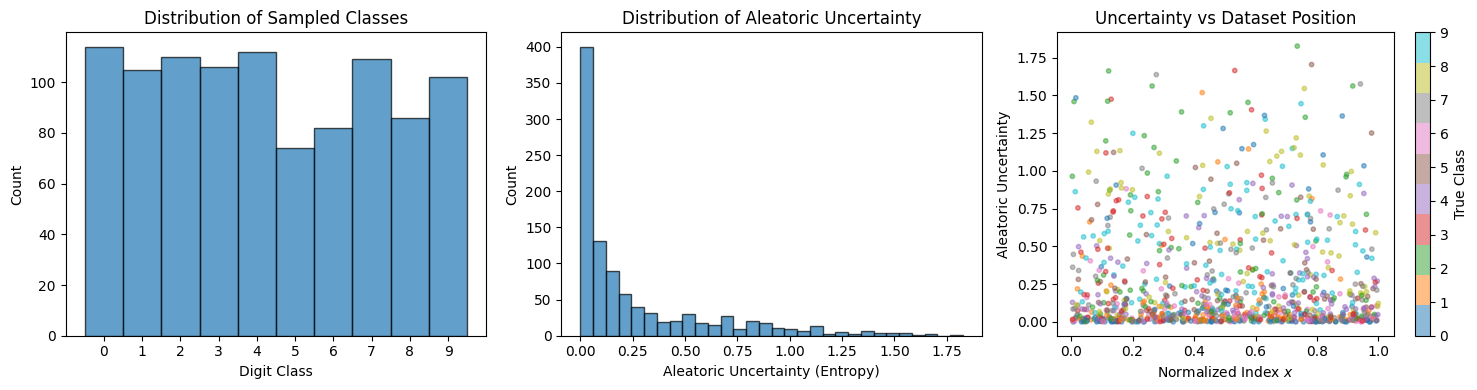

In [6]:
# ============================================================================
# Update MNIST Probability Function with Trained Model
# ============================================================================

# Now use the trained model for probability estimation
mnist_p_fn_model = MNISTProbabilityFunction(
    train_dataset, 
    model=mnist_model, 
    use_true_labels=False,
    temperature=1.0
)

# Generate data using the model-based probability function
rng_mnist = np.random.default_rng(42)
n_mnist_samples = 1000

X_mnist, Y_mnist, probs_mnist = mnist_dpg(
    n=n_mnist_samples,
    mnist_prob_fn=mnist_p_fn_model,
    rng=rng_mnist,
    sample_mode="uniform"
)

print(f"X_mnist shape: {X_mnist.shape}")  # (n, 1) normalized indices
print(f"Y_mnist shape: {Y_mnist.shape}")  # (n,) class labels
print(f"probs_mnist shape: {probs_mnist.shape}")  # (n, 10) probability distributions

# Compute aleatoric uncertainty
AU_mnist = -np.sum(probs_mnist * np.log(probs_mnist + 1e-12), axis=-1)
print(f"\nAleatoric Uncertainty stats:")
print(f"  Min: {AU_mnist.min():.4f}, Max: {AU_mnist.max():.4f}, Mean: {AU_mnist.mean():.4f}")

# Visualize distribution of classes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Class distribution
axes[0].hist(Y_mnist, bins=np.arange(11) - 0.5, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Digit Class")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Sampled Classes")
axes[0].set_xticks(range(10))

# Aleatoric uncertainty distribution
axes[1].hist(AU_mnist, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel("Aleatoric Uncertainty (Entropy)")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of Aleatoric Uncertainty")

# X (normalized index) vs Uncertainty
axes[2].scatter(X_mnist.flatten(), AU_mnist, c=Y_mnist, cmap='tab10', alpha=0.5, s=10)
axes[2].set_xlabel("Normalized Index $x$")
axes[2].set_ylabel("Aleatoric Uncertainty")
axes[2].set_title("Uncertainty vs Dataset Position")
plt.colorbar(axes[2].collections[0], ax=axes[2], label="True Class")

plt.tight_layout()
plt.show()

In [36]:
# ============================================================================
# MNIST Counterfactual Problem Formulation - IMAGE SPACE VERSION
# ============================================================================
# 
# Key difference: Instead of searching in 1D index space, we now search in
# the actual image pixel space (IMG_SIZE×IMG_SIZE dimensions).
# Using 16×16 = 256 dimensions (reduced from 28×28 = 784 for faster optimization)
# This allows finding counterfactual images that may NOT exist in the dataset!
# ============================================================================

def make_mnist_cf_problem_image_space(
    model: nn.Module,  # trained MNIST classifier
    x_star_image: np.ndarray,  # factual image, shape (IMG_SIZE, IMG_SIZE) or (1, IMG_SIZE, IMG_SIZE)
    target_class: int,  # desired counterfactual class
    X_obs_images: np.ndarray = None,  # observed images for plausibility
    models: list = None,  # ensemble of models for uncertainty estimation
    k: int = 5,
    device: str = "cuda",
    pixel_range: tuple = (-1.0, 1.0),  # normalized pixel range (after transform)
    img_size: int = 16,  # image size (16 for reduced, 28 for original)
):
    """
    Create a multi-objective counterfactual problem for MNIST in IMAGE SPACE.
    
    The decision variables are the img_size×img_size pixel values.
    
    Objectives:
        o1: Validity - probability of target class (minimize 1 - p_target)
        o2: Similarity - L2 distance in pixel space
        o3: Sparsity - number of changed pixels (L0 norm)
        o4: Plausibility - distance to k-nearest observed images
        o5: Aleatoric Uncertainty (to maximize, so we minimize negative)
        o6: Epistemic Uncertainty (if ensemble provided)
    
    Args:
        model: Trained classifier
        x_star_image: Factual image (img_size×img_size)
        target_class: Target class for counterfactual
        X_obs_images: Optional observed images for plausibility
        models: Optional ensemble for epistemic uncertainty
        k: Number of neighbors for plausibility
        device: torch device
        pixel_range: (min, max) valid pixel values
        img_size: Size of the images (default 16 for reduced search space)
    """
    # Flatten the factual image
    x_star_flat = x_star_image.flatten()
    n_pixels = len(x_star_flat)  # img_size*img_size (256 for 16x16, 784 for 28x28)
    
    # Feature space bounds (pixel values)
    xl = np.full(n_pixels, pixel_range[0])
    xu = np.full(n_pixels, pixel_range[1])
    
    # Precompute flattened observed images for plausibility
    if X_obs_images is not None:
        X_obs_flat = X_obs_images.reshape(len(X_obs_images), -1)
    else:
        X_obs_flat = None
    
    def image_to_tensor(x_flat):
        """Convert flat numpy array to torch tensor for model input."""
        img = x_flat.reshape(1, 1, img_size, img_size)  # (batch, channel, H, W)
        return torch.tensor(img, dtype=torch.float32).to(device)
    
    def get_model_probs(x_flat, m=None):
        """Get probability distribution from model."""
        m = m if m is not None else model
        m.eval()
        img_tensor = image_to_tensor(x_flat)
        with torch.no_grad():
            logits = m(img_tensor)
            probs = nn.Softmax(dim=1)(logits).cpu().numpy()[0]
        return probs
    
    def k_nearest_images(x_flat, k=5):
        """Find k nearest images in X_obs based on L2 distance."""
        if X_obs_flat is None:
            return None
        dists = np.linalg.norm(X_obs_flat - x_flat, axis=1)
        nearest_idx = np.argsort(dists)[:k]
        return X_obs_flat[nearest_idx], dists[nearest_idx]
    
    # =========== OBJECTIVE FUNCTIONS ===========
    
    # 1) Validity: soft validity using target class probability
    def o1_validity(x):
        probs = get_model_probs(x)
        prob_target = probs[target_class]
        return 1.0 - prob_target  # minimize (1 - p_target)
    
    # 2) Similarity: L2 distance in pixel space (normalized)
    def o2_similarity(x):
        diff = x - x_star_flat
        l2_dist = np.linalg.norm(diff)
        # Normalize by max possible distance
        max_dist = np.sqrt(n_pixels) * (pixel_range[1] - pixel_range[0])
        return l2_dist / max_dist
    
    # 3) Sparsity: number of significantly changed pixels (L0-like)
    def o3_sparsity(x):
        EPS = 0.05 * (pixel_range[1] - pixel_range[0])  # 5% of pixel range
        changed = np.abs(x - x_star_flat) > EPS
        return float(np.sum(changed)) / n_pixels  # normalize by total pixels
    
    # 4) Plausibility: mean L2 distance to k nearest observed images
    def o4_plausibility(x):
        if X_obs_flat is None:
            return 0.0
        nearest_imgs, dists = k_nearest_images(x, k=k)
        return float(np.mean(dists)) / np.sqrt(n_pixels)  # normalized
    
    # 5) Aleatoric Uncertainty (negative, to maximize)
    def o5_aleatoric_uncertainty(x):
        if models is None or len(models) == 0:
            # Use single model entropy
            probs = get_model_probs(x)
            entropy = -np.sum(probs * np.log(probs + 1e-12))
            return -entropy
        
        # Average entropy across ensemble
        au = 0.0
        for m in models:
            probs = get_model_probs(x, m)
            au += -np.sum(probs * np.log(probs + 1e-12))
        au /= len(models)
        return -au  # negative because we want to maximize
    
    # 6) Epistemic Uncertainty (if ensemble available)
    def o6_epistemic_uncertainty(x):
        if models is None or len(models) == 0:
            return 0.0
        
        # Collect predictions from all models
        all_probs = []
        for m in models:
            probs = get_model_probs(x, m)
            all_probs.append(probs)
        
        all_probs = np.array(all_probs)
        
        # Total uncertainty: entropy of mean prediction
        mean_probs = np.mean(all_probs, axis=0)
        TU = -np.sum(mean_probs * np.log(mean_probs + 1e-12))
        
        # Aleatoric uncertainty: mean of individual entropies
        AU = np.mean([-np.sum(p * np.log(p + 1e-12)) for p in all_probs])
        
        # Epistemic = Total - Aleatoric
        EU = TU - AU
        return EU 
    
    # Build objective list based on whether ensemble is provided
    if models is not None and len(models) > 0:
        # With ensemble: include AU, EU, and TU
        objectives = [
            o1_validity,           # Minimize 1 - P(target)
            o3_sparsity,           # Minimize changed pixels
            o5_aleatoric_uncertainty,  # Maximize AU (minimize -AU)
            o6_epistemic_uncertainty,  # Maximize EU (minimize -EU)
        ]
        obj_names = ['Validity', 'Sparsity', 'Aleatoric (AU)', 'Epistemic (EU)']
    else:
        # Single model: only use entropy as total uncertainty
        objectives = [
            o1_validity,
            o2_similarity,
            o3_sparsity,
            o4_plausibility
        ]
        obj_names = ['Validity', 'Similarity', 'Sparsity', 'Plausibility']
    
    print(f"Objectives: {obj_names}")
    
    return FunctionalProblem(
        n_var=n_pixels,
        objs=objectives,
        xl=xl, xu=xu,
        elementwise=True
    )


# ============================================================================
# Visualization for Image-Space Counterfactuals
# ============================================================================

def visualize_image_counterfactuals(
    model: nn.Module,
    x_star_image: np.ndarray,
    cf_images: np.ndarray,  # shape (n_cf, n_pixels) or (n_cf, img_size, img_size)
    target_class: int,
    factual_label: int,
    device: str = "cpu",
    img_size: int = 16,  # image size (16 for reduced, 28 for original)
):
    """Visualize factual and counterfactual images generated in pixel space."""
    
    n_cfs = min(len(cf_images), 25)  # Show max 8 counterfactuals
    
    fig, axes = plt.subplots(3, n_cfs + 1, figsize=(2.5 * (n_cfs + 1), 7))
    
    # Get factual predictions
    model.eval()
    x_star_flat = x_star_image.flatten()
    with torch.no_grad():
        img_tensor = torch.tensor(x_star_flat.reshape(1, 1, img_size, img_size), dtype=torch.float32).to(device)
        probs_star = nn.Softmax(dim=1)(model(img_tensor)).cpu().numpy()[0]
    
    # Factual image
    axes[0, 0].imshow(x_star_image.reshape(img_size, img_size), cmap='gray', vmin=-1, vmax=1)
    axes[0, 0].set_title(f"Factual x*\nTrue: {factual_label}", fontsize=10)
    axes[0, 0].axis('off')
    
    # Probability bar chart for factual
    colors_star = ['green' if j == factual_label else 'blue' for j in range(10)]
    axes[1, 0].bar(range(10), probs_star, color=colors_star, alpha=0.7)
    axes[1, 0].set_xticks(range(10))
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_ylabel("P(Y|X)")
    axes[1, 0].set_title("Factual probs")
    
    # Difference placeholder (no difference for factual)
    axes[2, 0].imshow(np.zeros((img_size, img_size)), cmap='RdBu', vmin=-1, vmax=1)
    axes[2, 0].set_title("Diff: N/A")
    axes[2, 0].axis('off')
    
    # Counterfactual images
    for i in range(n_cfs):
        cf_flat = cf_images[i].flatten()
        cf_img = cf_flat.reshape(img_size, img_size)
        
        # Get CF predictions
        with torch.no_grad():
            cf_tensor = torch.tensor(cf_flat.reshape(1, 1, img_size, img_size), dtype=torch.float32).to(device)
            probs_cf = nn.Softmax(dim=1)(model(cf_tensor)).cpu().numpy()[0]
        
        pred_class = np.argmax(probs_cf)
        
        # CF image
        axes[0, i + 1].imshow(cf_img, cmap='gray', vmin=-1, vmax=1)
        axes[0, i + 1].set_title(f"CF {i+1}\nPred: {pred_class}", fontsize=9)
        axes[0, i + 1].axis('off')
        
        # Probability bar chart
        colors_cf = ['red' if j == target_class else 'blue' for j in range(10)]
        axes[1, i + 1].bar(range(10), probs_cf, color=colors_cf, alpha=0.7)
        axes[1, i + 1].set_xticks(range(10))
        axes[1, i + 1].set_ylim(0, 1)
        axes[1, i + 1].set_title(f"P(target)={probs_cf[target_class]:.2f}")
        
        # Difference image
        diff = cf_img - x_star_image.reshape(img_size, img_size)
        axes[2, i + 1].imshow(diff, cmap='RdBu', vmin=-1, vmax=1)
        l2 = np.linalg.norm(diff)
        l0 = np.sum(np.abs(diff) > 0.05)
        axes[2, i + 1].set_title(f"L2={l2:.1f}, L0={l0}")
        axes[2, i + 1].axis('off')
    
    plt.suptitle(f"MNIST Image-Space Counterfactuals\nFactual: {factual_label} → Target: {target_class}", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return fig


# ============================================================================
# Helper: Get observed images from dataset
# ============================================================================

def get_mnist_images_subset(dataset, n_samples=500, seed=42):
    """Extract a subset of MNIST images as numpy arrays."""
    rng = np.random.default_rng(seed)
    indices = rng.choice(len(dataset), size=n_samples, replace=False)
    images = np.array([dataset[i][0].numpy().squeeze() for i in indices])
    labels = np.array([dataset[i][1] for i in indices])
    return images, labels, indices


print("MNIST Image-Space Counterfactual problem functions defined.")
print(f"Feature space: {IMG_SIZE}×{IMG_SIZE} = {IMG_SIZE*IMG_SIZE} dimensions")
print(f"This allows generating NEW images, not just finding existing ones!")

MNIST Image-Space Counterfactual problem functions defined.
Feature space: 16×16 = 256 dimensions
This allows generating NEW images, not just finding existing ones!


In [37]:
# ============================================================================
# Run MNIST Image-Space Counterfactual Generation with ENSEMBLE
# ============================================================================

# Select a factual instance
factual_digit = 3
target_digit = 8

# Find an index where the true label is the factual digit
factual_indices = np.where(mnist_p_fn_model._labels == factual_digit)[0]
x_star_idx = factual_indices[0]  # Pick the first one

# Get the actual image (not just the index!)
x_star_image = train_dataset[x_star_idx][0].numpy().squeeze()  # shape (IMG_SIZE, IMG_SIZE)
x_star_label = train_dataset[x_star_idx][1]

print(f"Factual instance:")
print(f"  Dataset index: {x_star_idx}")
print(f"  Image shape: {x_star_image.shape} ({IMG_SIZE}×{IMG_SIZE})")
print(f"  Pixel range: [{x_star_image.min():.2f}, {x_star_image.max():.2f}]")
print(f"  True label: {x_star_label}")
print(f"  Target class for counterfactual: {target_digit}")

# Get observed images for plausibility computation
print("\nGetting observed images for plausibility...")
X_obs_images, X_obs_labels, X_obs_indices = get_mnist_images_subset(
    train_dataset, n_samples=500, seed=42
)
print(f"  Observed images shape: {X_obs_images.shape}")

# ============================================================================
# Demonstrate Ensemble Uncertainty Decomposition
# ============================================================================
print("\n" + "="*60)
print("Ensemble Uncertainty Decomposition Demo")
print("="*60)

def compute_ensemble_uncertainties(x_image, ensemble, device, img_size):
    """
    Compute proper uncertainty decomposition from ensemble:
    - TU (Total Uncertainty) = entropy of mean prediction
    - AU (Aleatoric Uncertainty) = mean of individual entropies
    - EU (Epistemic Uncertainty) = TU - AU
    """
    # Collect predictions from all ensemble members
    all_probs = []
    for model in ensemble:
        model.eval()
        with torch.no_grad():
            img_tensor = torch.tensor(
                x_image.reshape(1, 1, img_size, img_size), 
                dtype=torch.float32
            ).to(device)
            logits = model(img_tensor)
            probs = nn.Softmax(dim=1)(logits).cpu().numpy()[0]
            all_probs.append(probs)
    
    all_probs = np.array(all_probs)  # Shape: (n_ensemble, n_classes)
    
    # Mean prediction across ensemble
    mean_probs = np.mean(all_probs, axis=0)
    
    # Total Uncertainty: entropy of mean prediction
    # TU = H(E[p]) = -sum(p_bar * log(p_bar))
    TU = -np.sum(mean_probs * np.log(mean_probs + 1e-12))
    
    # Aleatoric Uncertainty: mean of individual entropies
    # AU = E[H(p)] = mean(-sum(p_i * log(p_i)))
    individual_entropies = [-np.sum(p * np.log(p + 1e-12)) for p in all_probs]
    AU = np.mean(individual_entropies)
    
    # Epistemic Uncertainty: TU - AU
    # EU captures model disagreement
    EU = TU - AU
    
    return {
        'TU': TU,
        'AU': AU,
        'EU': EU,
        'mean_probs': mean_probs,
        'all_probs': all_probs,
        'pred_class': np.argmax(mean_probs),
        'individual_entropies': individual_entropies
    }

# Show ensemble predictions and uncertainties for the factual image
unc_factual = compute_ensemble_uncertainties(x_star_image, ensemble_models, device, IMG_SIZE)

print(f"\nFactual Image (digit {factual_digit}):")
print(f"  Ensemble prediction: {unc_factual['pred_class']}")
print(f"  Mean P({factual_digit}) = {unc_factual['mean_probs'][factual_digit]:.4f}")
print(f"\nUncertainty Decomposition:")
print(f"  Total Uncertainty (TU)     = {unc_factual['TU']:.4f}")
print(f"  Aleatoric Uncertainty (AU) = {unc_factual['AU']:.4f}")
print(f"  Epistemic Uncertainty (EU) = {unc_factual['EU']:.4f}")
print(f"  (TU = AU + EU check: {unc_factual['AU'] + unc_factual['EU']:.4f})")

# Visualize ensemble agreement
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Factual image
axes[0].imshow(x_star_image, cmap='gray')
axes[0].set_title(f"Factual Image (digit {factual_digit})")
axes[0].axis('off')

# Individual model predictions
for i, probs in enumerate(unc_factual['all_probs']):
    axes[1].plot(range(10), probs, 'o-', alpha=0.5, label=f'Model {i+1}')
axes[1].plot(range(10), unc_factual['mean_probs'], 'k-', linewidth=2, label='Ensemble Mean')
axes[1].set_xlabel("Digit Class")
axes[1].set_ylabel("P(Y|X)")
axes[1].set_title("Ensemble Predictions")
axes[1].set_xticks(range(10))
axes[1].legend(fontsize=8)

# Uncertainty bar chart
unc_names = ['TU\n(Total)', 'AU\n(Aleatoric)', 'EU\n(Epistemic)']
unc_values = [unc_factual['TU'], unc_factual['AU'], unc_factual['EU']]
colors = ['purple', 'blue', 'red']
axes[2].bar(unc_names, unc_values, color=colors, alpha=0.7)
axes[2].set_ylabel("Uncertainty (nats)")
axes[2].set_title("Uncertainty Decomposition\nTU = AU + EU")
for i, v in enumerate(unc_values):
    axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# Create the IMAGE-SPACE counterfactual problem WITH ENSEMBLE
# ============================================================================
print("\nCreating image-space counterfactual problem with ensemble...")
mnist_problem_img = make_mnist_cf_problem_image_space(
    model=mnist_model,  # Primary model (first in ensemble)
    x_star_image=x_star_image,
    target_class=target_digit,
    X_obs_images=X_obs_images,
    models=ensemble_models,  # ENSEMBLE for uncertainty estimation!
    k=5,
    device=device,
    pixel_range=(-1.0, 1.0),  # MNIST normalized range
    img_size=IMG_SIZE  # Use configured image size
)

print(f"Problem created:")
print(f"  Variables (pixels): {mnist_problem_img.n_var} ({IMG_SIZE}×{IMG_SIZE})")
print(f"  Objectives: {len(mnist_problem_img.objs)}")
print(f"  Pixel bounds: [{mnist_problem_img.xl[0]:.1f}, {mnist_problem_img.xu[0]:.1f}]")
print(f"  Using ensemble of {len(ensemble_models)} models for uncertainty!")

Factual instance:
  Dataset index: 7
  Image shape: (16, 16) (16×16)
  Pixel range: [-1.00, 0.96]
  True label: 3
  Target class for counterfactual: 8

Getting observed images for plausibility...
  Observed images shape: (500, 16, 16)

Ensemble Uncertainty Decomposition Demo


RuntimeError: Expected all tensors to be on the same device, but got weight is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA___slow_conv2d_forward)

In [ ]:
# ============================================================================
# Optimize using NSGA-II in Image Space
# ============================================================================
# Note: Using 16×16 = 256 dimensional optimization (reduced from 28×28 = 784).
# This significantly speeds up the search while still finding good counterfactuals.

from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.termination import Termination
from pymoo.core.callback import Callback

n_pixels = IMG_SIZE * IMG_SIZE  # 256 for 16×16, 784 for 28×28

# Custom sampling: start from the factual image with small perturbations
class FactualBasedSampling(FloatRandomSampling):
    def __init__(self, x_star, noise_scale=0.1):
        super().__init__()
        self.x_star = x_star.flatten()
        self.noise_scale = noise_scale
    
    def _do(self, problem, n_samples, **kwargs):
        # Generate samples around the factual image
        X = np.tile(self.x_star, (n_samples, 1))
        noise = np.random.uniform(-self.noise_scale, self.noise_scale, X.shape)
        X = X + noise
        # Clip to bounds
        X = np.clip(X, problem.xl, problem.xu)
        return X

# Custom callback to print valid counterfactual count during optimization
class ValidCFCallback(Callback):
    def __init__(self, validity_threshold=0.5, print_every=10):
        super().__init__()
        self.validity_threshold = validity_threshold
        self.print_every = print_every
        self.history = []  # Track history of valid CF counts
    
    def notify(self, algorithm):
        gen = algorithm.n_gen
        F = algorithm.pop.get("F")
        
        if F is not None:
            # Count valid counterfactuals in current population
            n_valid_pop = np.sum(F[:, 0] < self.validity_threshold)
            
            # Also check the archive/result if available
            if algorithm.opt is not None:
                F_opt = algorithm.opt.get("F")
                n_valid_opt = np.sum(F_opt[:, 0] < self.validity_threshold)
            else:
                n_valid_opt = 0
            
            # Best validity (lowest 1 - p_target)
            best_validity = F[:, 0].min()
            best_p_target = 1.0 - best_validity
            
            # Store history
            self.history.append({
                'gen': gen,
                'n_valid_pop': n_valid_pop,
                'n_valid_opt': n_valid_opt,
                'best_p_target': best_p_target
            })
            
            # Print progress every N generations
            if gen % self.print_every == 0 or gen == 1:
                print(f"Gen {gen:4d} | Valid CFs (pop): {n_valid_pop:3d} | "
                      f"Valid CFs (archive): {n_valid_opt:3d} | "
                      f"Best P(target): {best_p_target:.3f}")

# Custom termination: stop when more than N valid counterfactuals are found
class ValidCounterfactualTermination(Termination):
    def __init__(self, min_valid_cf=10, validity_threshold=0.5, min_gen=20, max_gen=200):
        """
        Terminate when more than min_valid_cf counterfactuals with 
        P(target) > (1 - validity_threshold) are found, AND min_gen is reached.
        
        Args:
            min_valid_cf: Minimum number of valid counterfactuals to find
            validity_threshold: F[0] < validity_threshold means valid (since F[0] = 1 - p_target)
            min_gen: Minimum number of generations before allowing termination
            max_gen: Maximum generations as fallback
        """
        super().__init__()
        self.min_valid_cf = min_valid_cf
        self.validity_threshold = validity_threshold
        self.min_gen = min_gen
        self.max_gen = max_gen
    
    def _update(self, algorithm):
        # Get current population's objective values
        F = algorithm.pop.get("F")
        
        if F is not None:
            # Count valid counterfactuals: F[:, 0] < validity_threshold
            # means 1 - p_target < threshold, so p_target > 1 - threshold
            n_valid = np.sum(F[:, 0] < self.validity_threshold)
            
            # Check termination conditions (only after min_gen reached)
            if algorithm.n_gen >= self.min_gen and n_valid > self.min_valid_cf:
                return 1.0  # Terminate: found enough valid CFs after minimum training
        
        # Fallback: also terminate if max generations reached
        if algorithm.n_gen >= self.max_gen:
            return 1.0
        
        return 0.0  # Continue

# Use factual-based sampling for better initialization
sampling = FactualBasedSampling(x_star_image, noise_scale=0.3)

algorithm_mnist_img = NSGA2(
    pop_size=250,  # Population size
    sampling=sampling,
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(prob=1.0/n_pixels, eta=20),  # Low mutation rate per pixel
)

# Terminate when more than 25 valid counterfactuals are found (or max 5000 generations)
# But only after at least min_gen generations have been completed
termination_mnist_img = ValidCounterfactualTermination(
    min_valid_cf=25, 
    validity_threshold=0.5,  # P(target) > 50%
    min_gen=200,  # Minimum generations before allowing early termination
    max_gen=600
)

# Callback to print progress
cf_callback = ValidCFCallback(validity_threshold=0.5, print_every=10)

print(f"Starting optimization in {n_pixels}-dimensional image space ({IMG_SIZE}×{IMG_SIZE})...")
print(f"Termination: when >25 valid counterfactuals found (after min 50 gens, max 5000 gens)")
print(f"Validity threshold: P(target) > 50%\n")
print("="*70)

res_mnist_img = minimize(
    mnist_problem_img, 
    algorithm_mnist_img, 
    termination_mnist_img, 
    callback=cf_callback,  # Add callback for progress tracking
    verbose=False,  # Disable default verbose, we use our callback
    seed=42
)

print("="*70)

F_mnist_img = res_mnist_img.F  # Objective values
X_mnist_cf_img = res_mnist_img.X  # Decision variables (pixel values per solution)

print(f"\nOptimization complete!")
print(f"Found {len(X_mnist_cf_img)} solutions on the Pareto front")
print(f"Objective values shape: {F_mnist_img.shape}")
print(f"Solution (image) shape: {X_mnist_cf_img.shape} ({IMG_SIZE}×{IMG_SIZE} pixels)")

# Filter for valid counterfactuals (high probability of target class)
validity_threshold = 0.5  # 1 - p_target < 0.5 means p_target > 0.5
valid_mask_img = F_mnist_img[:, 0] < validity_threshold
valid_X_img = X_mnist_cf_img[valid_mask_img]
valid_F_img = F_mnist_img[valid_mask_img]

print(f"\nValid counterfactuals (P(target) > {1-validity_threshold:.0%}): {len(valid_X_img)}")

Starting optimization in 256-dimensional image space (16×16)...
Termination: when >25 valid counterfactuals found (after min 50 gens, max 5000 gens)
Validity threshold: P(target) > 50%

Gen    1 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.004
Gen   10 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.017
Gen   20 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.034
Gen   30 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.074
Gen   40 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.106
Gen   50 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.198
Gen   60 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.286
Gen   70 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.431
Gen   80 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.492


KeyboardInterrupt: 

: 

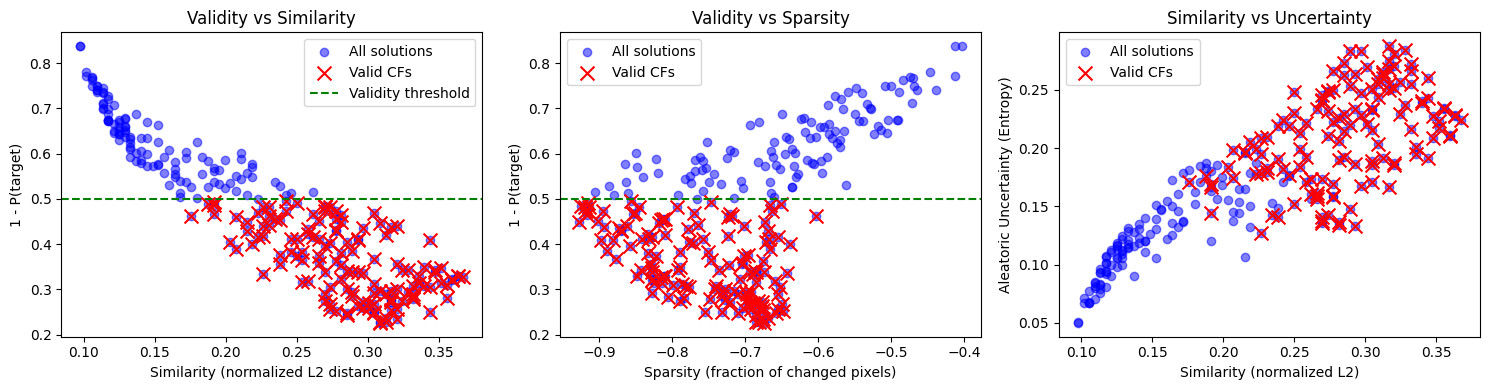

Visualizing valid counterfactual images...


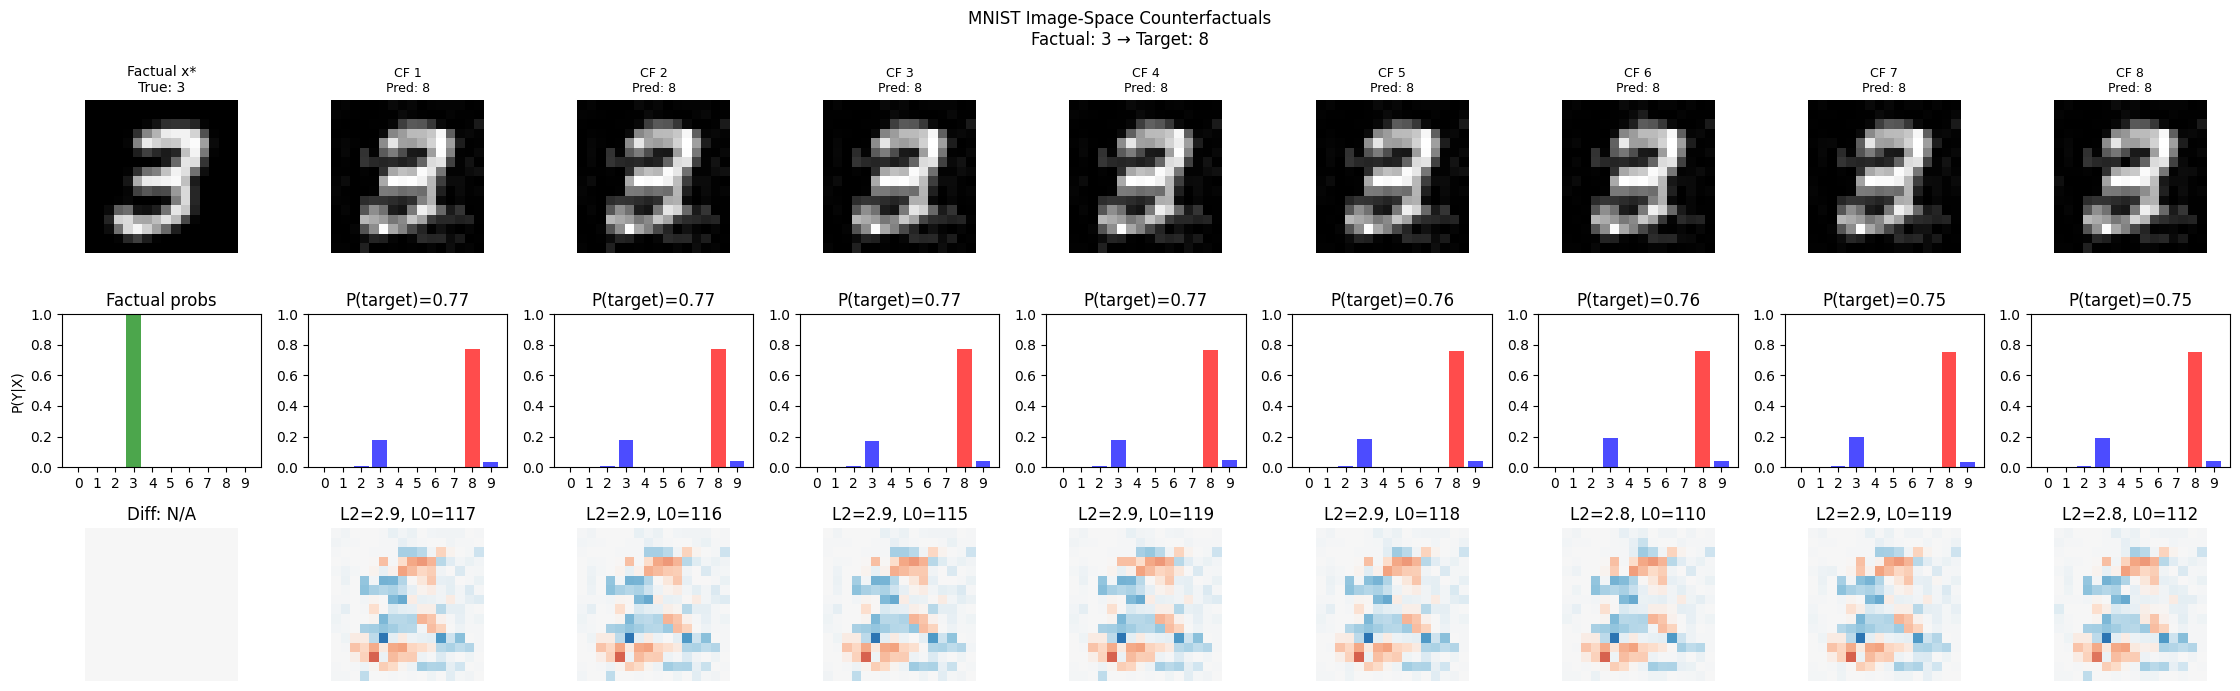

(250, 256)


In [10]:
# ============================================================================
# Visualize MNIST Image-Space Counterfactual Results
# ============================================================================

# Visualize Pareto front in objective space
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Validity vs Similarity (L2 distance)
axes[0].scatter(F_mnist_img[:, 1], F_mnist_img[:, 0], c='blue', alpha=0.5, label='All solutions')
if len(valid_F_img) > 0:
    axes[0].scatter(valid_F_img[:, 1], valid_F_img[:, 0], c='red', marker='x', s=100, label='Valid CFs')
axes[0].axhline(y=validity_threshold, color='green', linestyle='--', label=f'Validity threshold')
axes[0].set_xlabel("Similarity (normalized L2 distance)")
axes[0].set_ylabel("1 - P(target)")
axes[0].set_title("Validity vs Similarity")
axes[0].legend()

# Validity vs Sparsity (L0)
axes[1].scatter(F_mnist_img[:, 2], F_mnist_img[:, 0], c='blue', alpha=0.5, label='All solutions')
if len(valid_F_img) > 0:
    axes[1].scatter(valid_F_img[:, 2], valid_F_img[:, 0], c='red', marker='x', s=100, label='Valid CFs')
axes[1].axhline(y=validity_threshold, color='green', linestyle='--')
axes[1].set_xlabel("Sparsity (fraction of changed pixels)")
axes[1].set_ylabel("1 - P(target)")
axes[1].set_title("Validity vs Sparsity")
axes[1].legend()

# Similarity vs Aleatoric Uncertainty
axes[2].scatter(F_mnist_img[:, 1], -F_mnist_img[:, 3], c='blue', alpha=0.5, label='All solutions')
if len(valid_F_img) > 0:
    axes[2].scatter(valid_F_img[:, 1], -valid_F_img[:, 3], c='red', marker='x', s=100, label='Valid CFs')
axes[2].set_xlabel("Similarity (normalized L2)")
axes[2].set_ylabel("Aleatoric Uncertainty (Entropy)")
axes[2].set_title("Similarity vs Uncertainty")
axes[2].legend()

plt.tight_layout()
plt.show()

# Visualize the counterfactual IMAGES
if len(valid_X_img) > 0:
    print("Visualizing valid counterfactual images...")
    # Sort by validity (most valid first)
    sorted_idx = np.argsort(valid_F_img[:, 0])
    sorted_X = valid_X_img[sorted_idx][:8]  # Top 8 valid counterfactuals
    
    visualize_image_counterfactuals(
        model=mnist_model,
        x_star_image=x_star_image,
        cf_images=sorted_X,  # These are actual pixel values!
        target_class=target_digit,
        factual_label=factual_digit,
        device=device,
        img_size=IMG_SIZE
    )
else:
    print("No valid counterfactuals found.")
    print("Showing best attempts validated by validity metric...")
    

    
    # Show top solutions by validity even if not "valid"
    sorted_idx = np.argsort(F_mnist_img[:, 0])[:8]
    visualize_image_counterfactuals(
        model=mnist_model,
        x_star_image=x_star_image,
        cf_images=X_mnist_cf_img[sorted_idx],
        target_class=target_digit,
        factual_label=factual_digit,
        device=device,
        img_size=IMG_SIZE
    )
print (X_mnist_cf_img.shape)

### Data-Generating Process

Let $(\mathcal X,\Sigma_{\mathcal X})$ be the measurable input (feature) space and $(\mathcal Y,\Sigma_{\mathcal Y})$ the measurable output (target) space. Define the product space
$$
(\mathcal Z,\Sigma_{\mathcal Z}) := (\mathcal X\times\mathcal Y,\; \Sigma_{\mathcal X}\otimes \Sigma_{\mathcal Y}).
$$
The supervised learning problem is governed by an **unknown** probability measure
$$
P \in \mathcal P(\mathcal Z)
$$
on $(\mathcal Z,\Sigma_{\mathcal Z})$, called the *data-generating distribution*.
In ML notation we often write $\mathcal D := P$ and $(X,Y)\sim \mathcal D$.

---

### Assumption (i.i.d. sample)

Training data are obtained as $n$ i.i.d. draws from $P$ (equivalently $\mathcal D$):
$$
Z_i=(X_i,Y_i)\stackrel{\text{i.i.d.}}{\sim} P,\qquad i=1,\dots,n.
$$
This yields the dataset
$$
S \equiv D_n = \{(x_i,y_i)\}_{i=1}^n \in \mathcal Z^n, \qquad S\sim P^n=\mathcal D^n.
$$

---

### Marginal and Conditional Structure

Let $P_X$ (or $\mathcal D_X$) be the marginal of $P$ on $\mathcal X$:
$$
P_X(A)=P(A\times \mathcal Y),\qquad A\in\Sigma_{\mathcal X}.
$$
Assume a (regular) conditional distribution $P_{Y\mid X}(\cdot\mid x)\in\mathcal P(\mathcal Y)$ exists such that for all measurable $A\subseteq\mathcal X$ and $B\subseteq\mathcal Y$,
$$
P(A\times B)=\int_A P_{Y\mid X}(B\mid x)\,P_X(dx).
$$
When densities exist, this corresponds to the factorization
$$
p(x,y)=p_X(x)\,p_{Y\mid X}(y\mid x).
$$
Equivalently, sampling can be viewed as
$$
X_i\sim P_X,\qquad Y_i\sim P_{Y\mid X}(\cdot\mid X_i).
$$


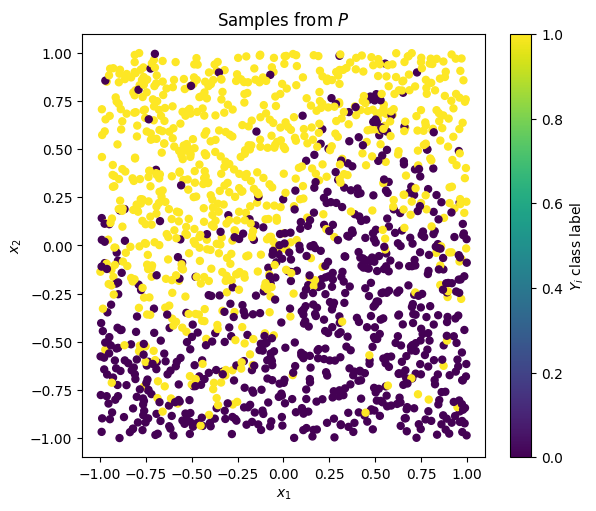

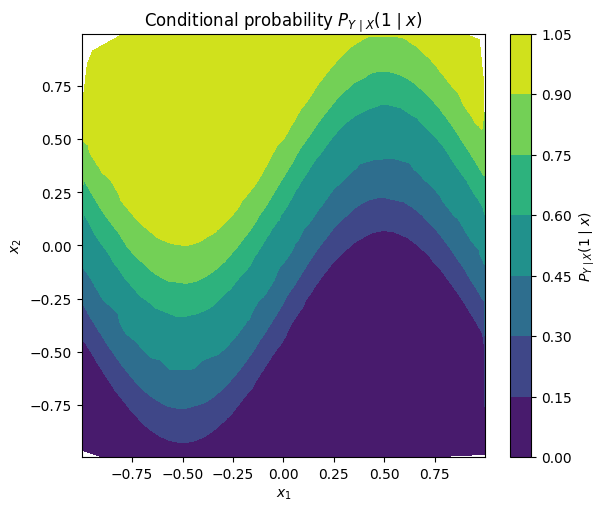

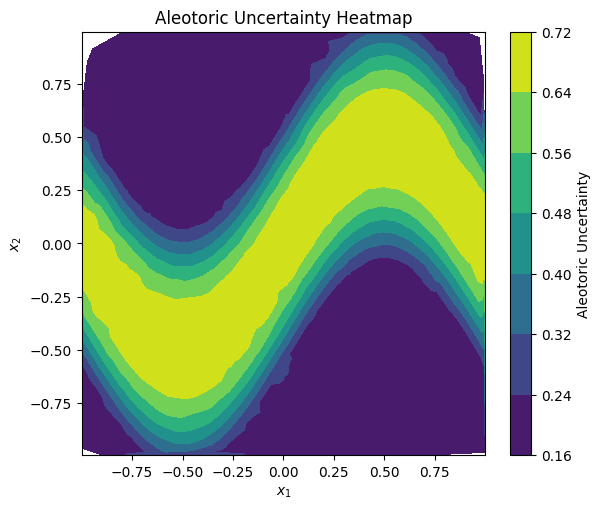

In [ ]:
import numpy as np
from functools import partial
from typing import Callable, Tuple, Optional

# ============================================================================
# Multi-class probability functions (p_fn)
# These return one-hot probability distributions: shape (n_samples, n_classes)
# ============================================================================

def boundary_focus_prob_multiclass(
    X: np.ndarray,
    n_classes: int = 2,
    r_inner=np.sqrt(2), r_outer=3.0,
    sigma=0.85,  # controls how fast uncertainty decays away from boundary
    max_uncertainty=0.89
) -> np.ndarray:
    """
    Returns a probability distribution over n_classes.
    For binary case (n_classes=2), behaves like original boundary_focus_prob.
    """
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    r = np.linalg.norm(X, axis=-1)

    base = ((r <= r_inner) | (r >= r_outer)).astype(float)
    dist_to_boundary = np.minimum(np.abs(r - r_inner), np.abs(r - r_outer))
    alpha = max_uncertainty * np.exp(-(dist_to_boundary / sigma) ** 2)

    p1 = base * (1 - alpha) + 0.5 * alpha
    p1 = np.clip(p1, 0.0, max_uncertainty)
    
    # Convert to multi-class probability distribution
    probs = np.zeros((X.shape[0], n_classes))
    probs[:, 0] = 1 - p1  # class 0
    probs[:, 1] = p1       # class 1
    # For more than 2 classes, distribute remaining probability uniformly
    if n_classes > 2:
        # Rescale so that all classes sum to 1
        remaining = 1.0 - probs[:, 0] - probs[:, 1]
        probs[:, 2:] = remaining[:, None] / (n_classes - 2)
        # Renormalize
        probs = probs / probs.sum(axis=-1, keepdims=True)
    
    return probs


def moon_focus_prob_multiclass(
    X: np.ndarray,
    n_classes: int = 2,
    sigma=0.4,  # controls how fast uncertainty decays away from boundary
    max_uncertainty=0.95,
    min_uncertainty=0.05,
) -> np.ndarray:
    """
    Returns a probability distribution over n_classes.
    For binary case (n_classes=2), behaves like original moon_focus_prob.
    """
    X = np.asarray(X)
    
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    x1, x2 = X[:, 0], X[:, 1]
    decision_boundary = np.sin(np.pi * x1) / 2
    dist_to_boundary = np.abs(x2 - decision_boundary)
    alpha = max_uncertainty * np.exp(-(dist_to_boundary / sigma) ** 2)
    p1 = 0.5 * alpha + (1 - alpha) * (x2 > decision_boundary).astype(float)
    p1 = np.clip(p1, min_uncertainty, max_uncertainty)
    
    # Convert to multi-class probability distribution
    probs = np.zeros((X.shape[0], n_classes))
    probs[:, 0] = 1 - p1  # class 0
    probs[:, 1] = p1       # class 1
    # For more than 2 classes, we can define regions or blend
    if n_classes > 2:
        # Example: distribute probability based on distance from origin
        # This is a simple extension; you may customize for your use case
        r = np.linalg.norm(X, axis=-1)
        for c in range(2, n_classes):
            # Create class-specific probability based on angular position
            angle = np.arctan2(X[:, 1], X[:, 0])
            sector_prob = 0.5 * (1 + np.cos(angle - 2 * np.pi * c / n_classes))
            probs[:, c] = sector_prob * alpha * 2  # small contribution
        # Renormalize
        probs = probs / probs.sum(axis=-1, keepdims=True)
    
    return probs


# Legacy wrappers for backward compatibility (binary classification)
def boundary_focus_prob(X: np.ndarray, **kwargs) -> np.ndarray:
    """Legacy wrapper: returns P(Y=1|X) for binary classification."""
    probs = boundary_focus_prob_multiclass(X, n_classes=2, **kwargs)
    return probs[:, 1]


def moon_focus_prob(X: np.ndarray, **kwargs) -> np.ndarray:
    """Legacy wrapper: returns P(Y=1|X) for binary classification."""
    probs = moon_focus_prob_multiclass(X, n_classes=2, **kwargs)
    return probs[:, 1]


# ============================================================================
# Aleatoric Uncertainty (works with multi-class probabilities)
# ============================================================================

def Aleotoric_Uncertainty_prob(
    p_fn: Callable[[np.ndarray], np.ndarray]
) -> Callable[[np.ndarray], np.ndarray]:
    """
    Computes aleatoric uncertainty (entropy) from a probability function.
    
    p_fn can return either:
      - Binary: shape (n,) with P(Y=1|X)
      - Multi-class: shape (n, n_classes) with full probability distribution
    """
    def wrapped_fn(X: np.ndarray) -> np.ndarray:
        probs = p_fn(X)
        probs = np.asarray(probs)
        
        # Handle binary case: convert p1 to [p0, p1]
        if probs.ndim == 1:
            p1 = probs
            p0 = 1.0 - p1
            probs = np.stack([p0, p1], axis=-1)
        
        # Compute entropy: H = -sum(p * log(p))
        # Add small epsilon to avoid log(0)
        uncertainty = -np.sum(probs * np.log(probs + 1e-12), axis=-1)
        return uncertainty
    return wrapped_fn


# ============================================================================
# Data Generating Process (DGP) - supports multi-class
# ============================================================================

def dpg(
    n: int,  # number of samples
    x_sampler: Callable[..., np.ndarray],  # represents P_X
    p_fn: Callable[[np.ndarray], np.ndarray],  # represents P_{Y|X}
    d: int = 2,  # number of features
    rng: Optional[np.random.Generator] = None,
    x_sampler_kwargs: Optional[dict] = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Data Generating Process for multi-class classification.
    
    X_i ~ P_X via x_sampler
    Y_i | X_i ~ Categorical(p_fn(X_i)) via numpy rng.choice
    
    p_fn can return either:
      - Binary: shape (n,) with P(Y=1|X) -> Y ~ Bernoulli
      - Multi-class: shape (n, n_classes) -> Y ~ Categorical
    
    Returns:
      X: features, shape (n, d)
      Y: labels, shape (n,) with integer class indices
      probs: probability distribution, shape (n,) for binary or (n, n_classes) for multi-class
    """
    rng = np.random.default_rng() if rng is None else rng
    x_sampler_kwargs = {} if x_sampler_kwargs is None else dict(x_sampler_kwargs)

    if "size" not in x_sampler_kwargs:
        x_sampler_kwargs["size"] = (n, d)

    X = np.asarray(x_sampler(**x_sampler_kwargs))
    probs = p_fn(X)
    probs = np.asarray(probs)
    
    # Handle binary case: p_fn returns p1 only
    if probs.ndim == 1:
        p1 = np.clip(probs, 0.0, 1.0)
        Y = rng.binomial(1, p1).astype(np.int64)
        return X, Y, p1
    
    # Multi-class case: p_fn returns full probability distribution
    probs = np.clip(probs, 0.0, 1.0)
    # Normalize to ensure valid probability distribution
    probs = probs / probs.sum(axis=-1, keepdims=True)
    
    n_classes = probs.shape[1]
    Y = np.array([
        rng.choice(n_classes, p=probs[i])
        for i in range(n)
    ], dtype=np.int64)
    
    return X, Y, probs


# ============================================================================
# Demo: Generate data with multi-class or binary
# ============================================================================

rng = np.random.default_rng(42)
x_sampler = partial(rng.uniform, low=-1, high=1)   # P_X

# Using legacy binary interface (backward compatible)
X, Y, p1 = dpg(
    n=1500,
    x_sampler=x_sampler,
    p_fn=moon_focus_prob,  # returns p1 only (binary)
    d=2,
    rng=rng
)

# Example: Multi-class version (uncomment to use)
# p_fn_multiclass = partial(moon_focus_prob_multiclass, n_classes=3)
# X, Y, probs = dpg(
#     n=1500,
#     x_sampler=x_sampler,
#     p_fn=p_fn_multiclass,  # returns full distribution
#     d=2,
#     rng=rng
# )


plt.figure(figsize=(6.5, 5.5))
plt.scatter(X[:, 0], X[:, 1], c=Y, s=25, cmap="viridis")
plt.colorbar(label=r"$Y_i$ class label")
plt.title("Samples from $P$ ")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

# use plt to generate heatmap of p1
plt.figure(figsize=(6.5, 5.5))
plt.tricontourf(X[:, 0], X[:, 1], p1, levels=7, cmap="viridis")
plt.colorbar(label=r"$P_{Y\mid X}(1\mid x)$")
plt.title("Conditional probability $P_{Y\mid X}(1\mid x)$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()


# AU_heatmap
AU_values = Aleotoric_Uncertainty_prob(moon_focus_prob)(X)
plt.figure(figsize=(6.5, 5.5))
plt.tricontourf(X[:, 0], X[:, 1], AU_values, levels=7, cmap="viridis")
plt.colorbar(label=r"Aleotoric Uncertainty")
plt.title("Aleotoric Uncertainty Heatmap")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

X shape: (1500, 2)
Y shape: (1500,), unique classes: [0 1 2]
probs shape: (1500, 3)
Sample probs (first 5):
[[8.94677608e-01 4.70882951e-02 5.82340971e-02]
 [4.17602897e-01 4.61806815e-01 1.20590288e-01]
 [4.99975312e-02 9.49953093e-01 4.93753997e-05]
 [4.49668445e-01 5.29378908e-01 2.09526470e-02]
 [1.55165761e-01 3.45159449e-01 4.99674790e-01]]


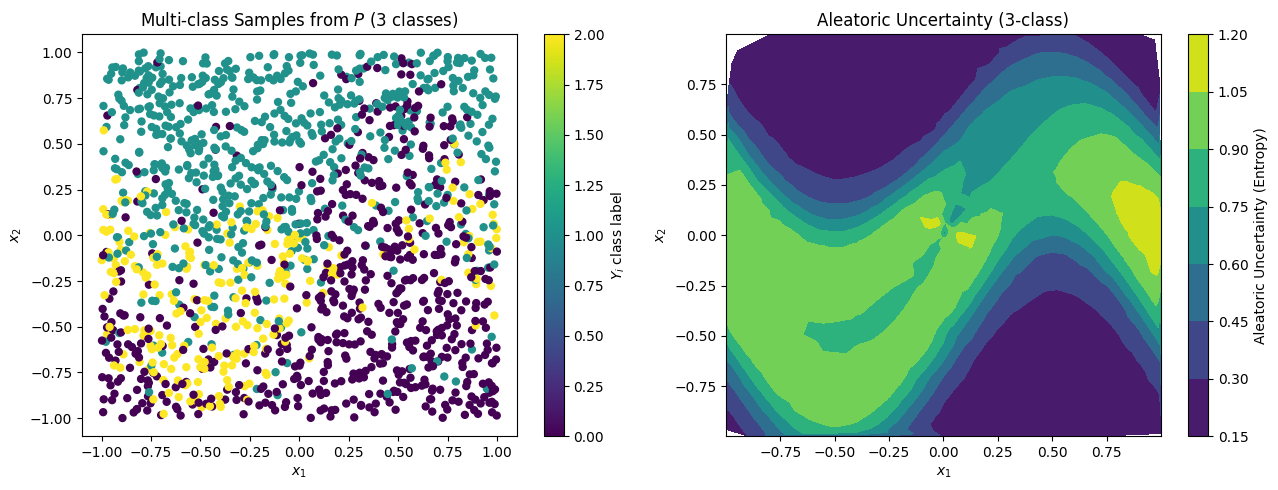

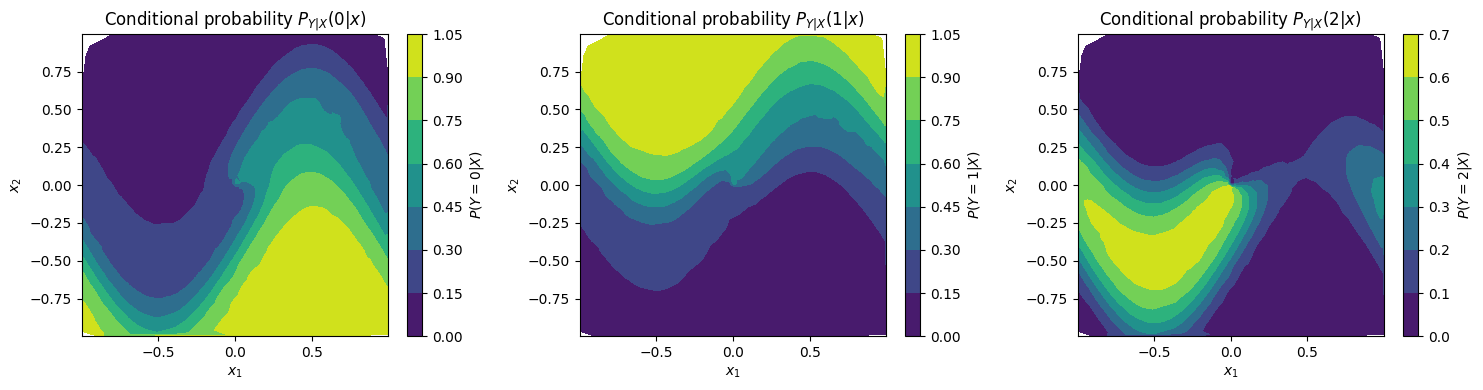

In [12]:
# ============================================================================
# Demo: Multi-class classification (3 classes)
# ============================================================================

rng_mc = np.random.default_rng(42)
x_sampler_mc = partial(rng_mc.uniform, low=-1, high=1)

# Create a multi-class probability function with 3 classes
p_fn_multiclass = partial(moon_focus_prob_multiclass, n_classes=3)

X, Y, probs_mc = dpg(
    n=1500,
    x_sampler=x_sampler_mc,
    p_fn=p_fn_multiclass,  # returns full distribution (n, 3)
    d=2,
    rng=rng_mc
)

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}, unique classes: {np.unique(Y)}")
print(f"probs shape: {probs_mc.shape}")
print(f"Sample probs (first 5):\n{probs_mc[:5]}")

# Plot multi-class samples
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: Scatter plot with class labels
scatter = axes[0].scatter(X[:, 0], X[:, 1], c=Y, s=25, cmap="viridis")
plt.colorbar(scatter, ax=axes[0], label=r"$Y_i$ class label")
axes[0].set_title("Multi-class Samples from $P$ (3 classes)")
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")

# Right: Aleatoric Uncertainty
AU_values_mc = Aleotoric_Uncertainty_prob(p_fn_multiclass)(X)
cntr = axes[1].tricontourf(X[:, 0], X[:, 1], AU_values_mc, levels=7, cmap="viridis")
plt.colorbar(cntr, ax=axes[1], label=r"Aleatoric Uncertainty (Entropy)")
axes[1].set_title("Aleatoric Uncertainty (3-class)")
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_2$")

plt.tight_layout()
plt.show()

# Plot probability for each class
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for c in range(3):
    cntr = axes[c].tricontourf(X[:, 0], X[:, 1], probs_mc[:, c], levels=7, cmap="viridis")
    plt.colorbar(cntr, ax=axes[c], label=f"$P(Y={c}|X)$")
    axes[c].set_title(f"Conditional probability $P_{{Y|X}}({c}|x)$")
    axes[c].set_xlabel("$x_1$")
    axes[c].set_ylabel("$x_2$")
plt.tight_layout()
plt.show()

In [13]:
 # index of max aleatoric uncertainty
AU_values_mc.max(),X[np.argmax(AU_values_mc, axis=0)], Y[np.argmax(AU_values_mc, axis=0)], probs_mc[np.argmax(AU_values_mc, axis=0)]

(np.float64(1.0975972102568854),
 array([ 0.99645696, -0.01507417]),
 np.int64(2),
 array([0.35409905, 0.31875668, 0.32714427]))

In [14]:
p_fn_multiclass(X[np.argmax(AU_values_mc, axis=0)])
# we calc the AU manually here for verification

prob=p_fn_multiclass(X[np.argmax(AU_values_mc, axis=0)])
prob,np.sum(prob, axis=-1), prob * np.log(prob),-np.sum(prob * np.log(prob), axis=-1)


(array([[0.35409905, 0.31875668, 0.32714427]]),
 array([1.]),
 array([[-0.36761806, -0.36444319, -0.36553596]]),
 array([1.09759721]))

In [15]:
device ="cpu" #"cuda" if torch.cuda.is_available() else "cpu"

dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        torch.tensor(Y, dtype=torch.long))
# X, Y = sklearn.datasets.make_moons(n_samples=300, noise=0.1, random_state=42)
# X = torch.tensor(X, dtype=torch.float32)
# Y = torch.tensor(Y, dtype=torch.long)
# dataset = TensorDataset(X, Y)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)


class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        return self.net(x)


model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [16]:
# training loop
num_epochs = 50

bar = tqdm(range(num_epochs), desc="Training", ncols=80, unit="epoch",colour="blue")
for epoch in bar:
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    bar.set_postfix({'Train Loss': epoch_loss})

# Validation
model.eval()
val_loss = 0.0
correct = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

val_loss /= len(val_loader.dataset)
val_accuracy = correct / len(val_loader.dataset)

bar.set_postfix({'Train Loss': epoch_loss, 'Val Loss': val_loss, 'Val Acc': val_accuracy})


Training: 100%|████████████| 50/50 [00:02<00:00, 18.25epoch/s, Train Loss=0.617]


In [17]:
model(torch.tensor(X[:5,:], dtype=torch.float32).to(device))

tensor([[ 0.4539, -0.6885, -0.8591],
        [ 0.1151,  0.3817, -1.9016],
        [-0.8838,  3.5494, -4.2667],
        [ 0.2743,  0.7175, -2.8135],
        [-0.9458,  0.3743,  0.6458]], grad_fn=<AddmmBackward0>)

((<Figure size 520x460 with 2 Axes>,
  <Axes: title={'center': 'Class 0 probability surface'}, xlabel='x0', ylabel='x1'>),
 (<Figure size 520x460 with 2 Axes>,
  <Axes: title={'center': 'Class 2 probability surface'}, xlabel='x0', ylabel='x1'>),
 (<Figure size 520x460 with 4 Axes>,
  <Axes: title={'center': 'Max-probability class regions'}, xlabel='x0', ylabel='x1'>))

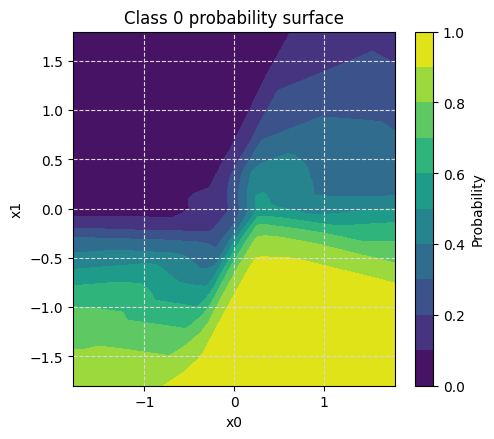

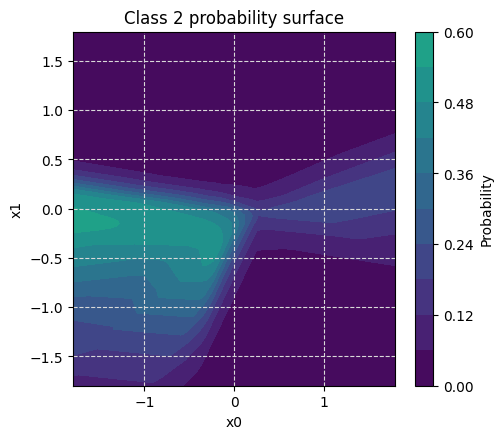

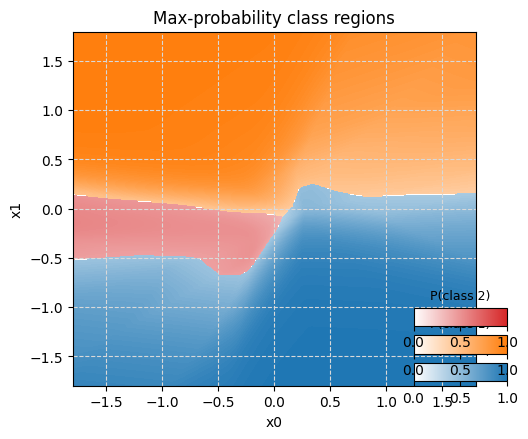

In [18]:
# visual
import importlib
import utils
importlib.reload(utils)
from utils import plot_proba

# class_of_interest options:
#   - "auto": binary->class 1, multi-class->max regions (default)
#   - None or "max": show max-probability class regions
#   - 0, 1, 2, ...: show probability surface for that specific class
#   - "all": show subplots for all classes

# Example: Show probability for class 1
plot_proba(model, X, levels=10,class_of_interest=0),plot_proba(model, X, levels=10, class_of_interest=2), plot_proba(model, X, levels=50)


Let $X$ be the feature space and $X_{\mathrm{obs}} \subseteq X$ the set of observed (factual) instances.
A candidate counterfactual is denoted by $\bar{x} \in X^{CF} \subseteq X$, where $X^{CF}$ is the feasible
counterfactual search space. The original (factual) instance is $x^\ast \in X_{\mathrm{obs}}$.
Each instance $x \in X$ has $p=\dim(x)$ features, written as
$x=(x_1,\dots,x_p)$ and $\bar{x}=(\bar{x}_1,\dots,\bar{x}_p)$.
Let $\hat{f}:X\to Y$ be the trained prediction model with output space $Y$,
and let $Y' \subseteq Y$ be the desired target-output set
(e.g., a target class or target interval).

For plausibility, let $x^{[1]},\dots,x^{[k]} \in X_{\mathrm{obs}}$ be the
$k$ nearest observed neighbors of $\bar{x}$ (according to a chosen distance),
with feature components $x^{[i]}=(x^{[i]}_1,\dots,x^{[i]}_p)$.
Their nonnegative weights are $w_{[i]}\ge 0$ and satisfy $\sum_{i=1}^k w_{[i]}=1$.

**Multi-objective counterfactual search**

We minimize the vector of objectives
$$
\min_{x}\,\mathbf{o}(\bar{x})
:= \min_{x}\Bigl(
o_1(\hat{f}(\bar{x}), Y'),\;
o_2(\bar{x}, x^\ast),\;
o_3(\bar{x}, x^\ast),\;
o_4(\bar{x}, X^{\mathrm{obs}})
\Bigr).
$$

***Objectives***

Validity
$$
o_1(\hat{f}(\bar{x}), Y') =
\begin{cases}
0, & \text{if } \hat{f}(\bar{x}) \in Y',\\[4pt]
\inf_{y' \in Y'} \lvert \hat{f}(\bar{x}) - y' \rvert, & \text{otherwise}.
\end{cases}
$$

Similarity
$$
o_2(\bar{x}, x^\ast)
= \frac{1}{p}\sum_{j=1}^{p} \delta_G(\bar{x}_j, x_j^\ast)
\in [0,1].
$$

Sparsity
$$
o_3(\bar{x}, x^\ast)
= \lVert \bar{x}-x^\ast\rVert_0
= \sum_{j=1}^{p} \mathbb{I}[\bar{x}_j \neq x_j^\ast],
$$
where $\lVert\cdot\rVert_0$ is the $\ell_0$ “norm” (the number of nonzero entries)
and $\mathbb{I}[\cdot]$ is the indicator function.

Plausibility

$$
o_4(\bar{x}, X^{\mathrm{obs}})
= \sum_{i=1}^{k} w_{[i]} \,\frac{1}{p}\sum_{j=1}^{p}
\delta_G(\bar{x}_j, x_{j}^{[i]})
\in [0,1],
\qquad
\sum_{i=1}^{k} w_{[i]} = 1.
$$

***Feature-wise dissimilarity/mean Gower distance***

For each feature $j\in\{1,\dots,p\}$, define
$$
\delta_G(u,v)=
\begin{cases}
R_j\,\lvert u - v \rvert, & \text{if feature } j \text{ is numerical},\\[4pt]
\mathbb{I}[u \neq v], & \text{if feature } j \text{ is categorical},
\end{cases}
$$
where $u$ and $v$ denote the compared values of the $j$-th feature, and
$$
R_j = \max(X_{:,j}) - \min(X_{:,j})
$$
is the empirical range of feature $j$ over the dataset $X$
(with $X_{:,j}$ the $j$-th column of $X$).


In [19]:
# now we repeating the data generation with the model training to get the different model weights and posterior distributions of the model parameters

num_repeats = 5
models = []

for repeat in range(num_repeats):
    rng = np.random.default_rng(42 + repeat)
    x_sampler = partial(rng.uniform, low=-1, high=1)   # P_X
    X, Y, p1 = dpg(
        n=1500,
        x_sampler=x_sampler,
        p_fn=moon_focus_prob,
        d=2,
        rng=rng
    )

    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                            torch.tensor(Y, dtype=torch.long))

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)


    _model = SimpleNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(_model.parameters(), lr=1e-3)


    # training loop
    num_epochs = 50

    bar = tqdm(range(num_epochs), desc=f"Model {repeat+1}", ncols=80, unit="epoch",colour="blue")
    for epoch in bar:
        _model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = _model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        bar.set_postfix({'Train Loss': epoch_loss})

    models.append(_model)

Model 5: 100%|█████████████| 50/50 [00:02<00:00, 18.35epoch/s, Train Loss=0.389]


Detected 3 classes


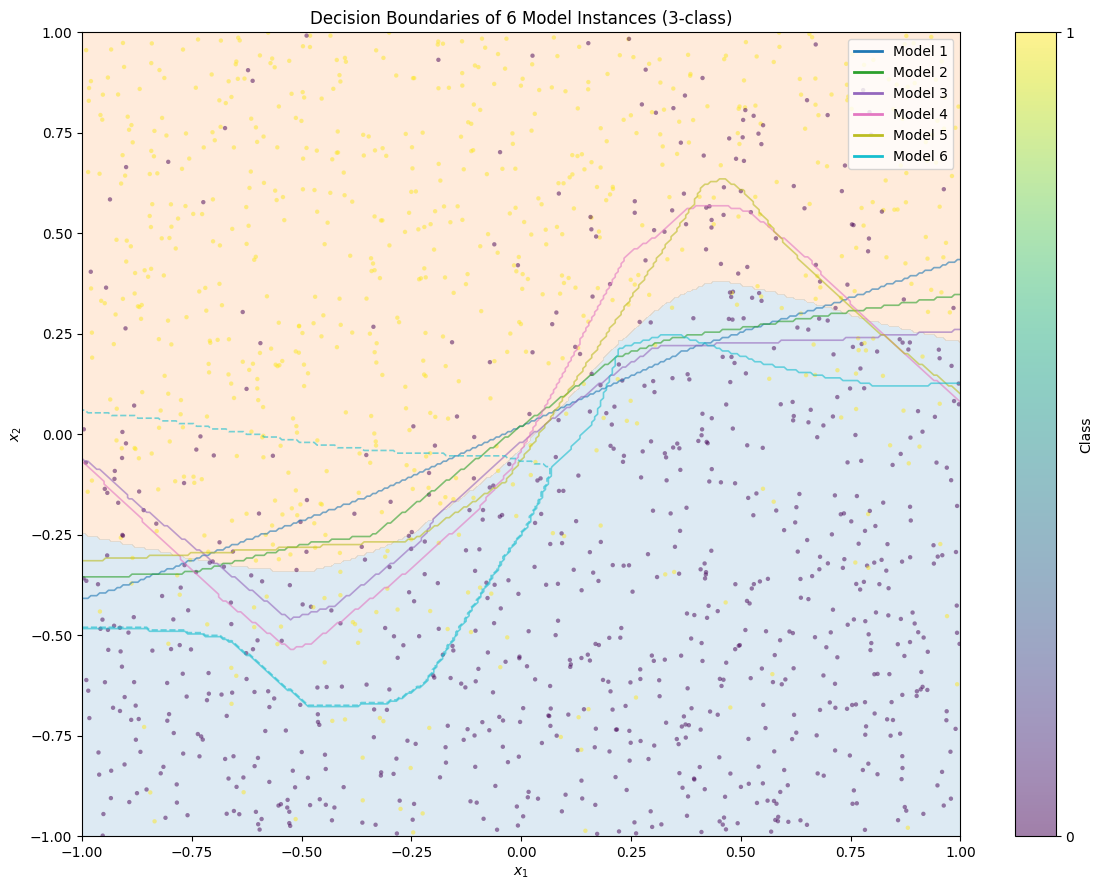

In [20]:
models.append(model)  # include the first model as well

# Draw multi-class decision boundaries for each model
# Works for both binary and multi-class classification

plt.figure(figsize=(12, 9))

xx, yy = np.meshgrid(np.linspace(-1, 1, 300), np.linspace(-1.0, 1, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Detect number of classes from first model output
with torch.no_grad():
    sample_out = model(torch.tensor(grid[:1], dtype=torch.float32).to(device))
    n_classes = sample_out.shape[1]

print(f"Detected {n_classes} classes")

# Color palette for models (different models get different colors)
model_colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

# Class boundary colors (consistent across models)
class_colors = ['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c', '#9467bd', '#8c564b']

for i, _model in enumerate(models):
    _model.eval()
    with torch.no_grad():
        Z = _model(torch.tensor(grid, dtype=torch.float32).to(device)).detach().cpu().numpy()
    
    # Get predicted class for each grid point
    Z_class = np.argmax(Z, axis=1).reshape(xx.shape)
    
    if n_classes == 2:
        # Binary: single decision boundary at 0.5
        plt.contour(xx, yy, Z_class, levels=[0.5], 
                   colors=[model_colors[i]], alpha=0.7, linewidths=1.5)
    else:
        # Multi-class: draw boundaries between all class regions
        # Use contour at each class transition
        for c in range(n_classes - 1):
            cs = plt.contour(xx, yy, Z_class, levels=[c + 0.5], 
                            colors=[model_colors[i]], alpha=0.6, linewidths=1.2,
                            linestyles=['solid', 'dashed', 'dotted'][c % 3])

# Add filled regions showing mean prediction across models (optional overlay)
mean_probs = np.zeros((grid.shape[0], n_classes))
for _model in models:
    _model.eval()
    with torch.no_grad():
        probs = nn.Softmax(dim=1)(_model(torch.tensor(grid, dtype=torch.float32).to(device))).cpu().numpy()
    mean_probs += probs
mean_probs /= len(models)

# Background: show ensemble mean class prediction
Z_ensemble = np.argmax(mean_probs, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z_ensemble, levels=np.arange(-0.5, n_classes, 1), 
             colors=class_colors[:n_classes], alpha=0.15)

# Scatter the data points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=10, alpha=0.5, edgecolors='none')

# Create legend entries for models
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=model_colors[i], linewidth=2, 
                          label=f'Model {i+1}') for i in range(len(models))]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Decision Boundaries of {len(models)} Model Instances ({n_classes}-class)")
plt.colorbar(label="Class", ticks=range(n_classes))
plt.tight_layout()
plt.show()

C:\Users\yuanl\AppData\Local\Temp\ipykernel_5100\200124488.py:27: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, label='Ensemble Boundary')
C:\Users\yuanl\AppData\Local\Temp\ipykernel_5100\200124488.py:32: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, label='Ensemble Boundary')


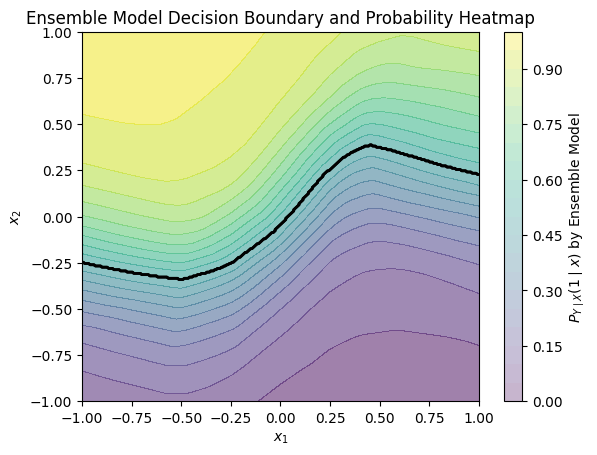

In [21]:
# now we build the emsemble model
from typing_extensions import Self


class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = models

    def forward(self, x):
        # Average the outputs of all models
        outputs = [model(x) for model in self.models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output
    
    def eval(self) -> Self:
        super().eval()
        for model in self.models:
            model.eval()
        return self
ensemble_model = EnsembleModel(models).to(device)
ensemble_model.eval()
logits = ensemble_model(torch.tensor(grid, dtype=torch.float32).to(device)).detach().cpu().numpy()
probs = nn.Softmax(dim=1)(torch.tensor(logits)).numpy()
Z = np.argmax(probs, axis=1).reshape(xx.shape)
plt.tricontourf(grid[:, 0], grid[:, 1], probs[:, 1], levels=20, cmap="viridis", alpha=0.3)
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, label='Ensemble Boundary')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Ensemble Model Decision Boundary and Probability Heatmap")
cntr = plt.tricontourf(grid[:, 0], grid[:, 1], probs[:, 1], levels=20, cmap="viridis", alpha=0.3)
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, label='Ensemble Boundary')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Ensemble Model Decision Boundary and Probability Heatmap")
plt.colorbar(cntr, label=r"$P_{Y\mid X}(1\mid x)$ by Ensemble Model")
plt.show()

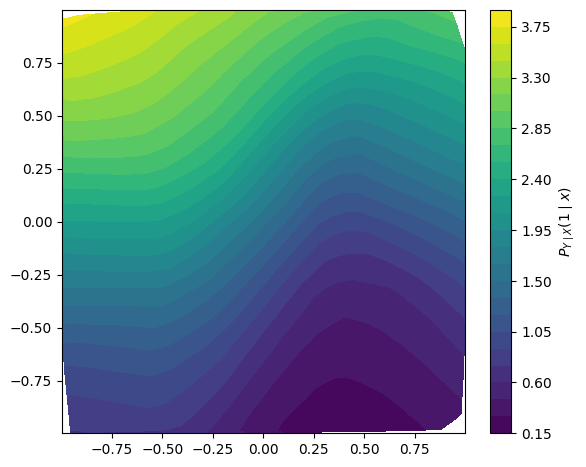

In [22]:
# Plot decision boundary
plt.figure(figsize=(6.5, 5.5))
plt.tricontourf(X[:, 0], X[:, 1], ensemble_model(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu().numpy()[:,1], levels=25, cmap="viridis")
plt.colorbar(label=r"$P_{Y\mid X}(1\mid x)$")

In [23]:
def make_cf_problem(model, x_star, Y_prime, X_obs, weights, k=5, bayesian_model=None, models=None):
    model.eval()
    bayesian_model.eval() if bayesian_model is not None else None

    x_star_np = x_star.detach().cpu().numpy()
    X_obs_np = X_obs.detach().cpu().numpy()
    w_np = weights.detach().cpu().numpy()
    w_np = w_np / (w_np.sum() + 1e-12)

    p = x_star_np.shape[0]

    xl = X_obs_np.min(axis=0)
    xu = X_obs_np.max(axis=0)
    feature_range = xu - xl
    feature_range[feature_range == 0] = 1.0

    target_labels = Y_prime.view(-1).long().tolist()

    def delta_G_vec(x, y):
        return np.minimum(np.abs(x - y) / feature_range, 1.0)
    
    def k_nearest(x, k=5):
        dists = np.linalg.norm(X_obs_np - x, axis=1)
        nearest_indices = np.argsort(dists)[:k]
        return X_obs_np[nearest_indices]

    # 1) Validity: distance to target in probability space
    def o1_validity(x):
        x_t = torch.from_numpy(x.astype(np.float32)).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x_t).argmax(dim=1).item()
        return 0.0 if pred in target_labels else 1.0
    
    def soft_o1_validity(x):
        x_t = torch.from_numpy(x.astype(np.float32)).unsqueeze(0).to(device)
        with torch.no_grad():
            probs = nn.Softmax(dim=1)(model(x_t))
        prob_target = probs[0, target_labels].sum().item()
        return 1.0 - prob_target

    # 2) Similarity
    def o2_similarity(x):
        return float(delta_G_vec(x, x_star_np).mean())

    # 3) Sparsity (L0)
    EPS = 0.005
    def o3_sparsity(x):
        diff=0
        for i in range(len(x_star_np)):
            if abs(x[i] - x_star_np[i]) > EPS:
                diff += 1
        return float(diff)     

    def o4_plausibility(x):
    # mean Gower distance to k nearest obs sample, then weighted sum
        nearest_samples = k_nearest(x, k=5)
        per_sample = np.array([delta_G_vec(x, x_i).mean()
                            for x_i in nearest_samples])
        return float((per_sample * w_np).sum())
    
    def aleatoric_uncertainty(x):
        if not models:
            raise ValueError("Ensemble models must be provided for aleatoric uncertainty calculation.")
        x_t = torch.from_numpy(x.astype(np.float32)).unsqueeze(0).to(device)
        au=0
        with torch.no_grad():
            for m in models:
                probs = nn.Softmax(dim=1)(m(x_t)).cpu().numpy()
                p1 = probs[0, 1]
                p0 = probs[0, 0]
                au+=-np.sum(np.array([p0, p1]) * np.log(np.array([p0, p1]) + 1e-12))
        au=au/len(models)
        return float(au)
    
    # since our goal is to maximize aleatoric uncertainty, we minimize its negative value
    def o5_aleatoric_uncertainty(x):
        
        return -aleatoric_uncertainty(x)
    
    def Total_Uncertainty(x):
        if not model:
            raise ValueError("Bayesian model must be provided for total uncertainty calculation.")
        probs0=0
        probs1=0
        for m in models:
            x_t = torch.from_numpy(x.astype(np.float32)).unsqueeze(0).to(device)
            with torch.no_grad():
                probs = nn.Softmax(dim=1)(m(x_t)).cpu().numpy()
                probs0+=probs[0,0]
                probs1+=probs[0,1]
        probs0=probs0/len(models)
        probs1=probs1/len(models)
        TU=-np.sum(np.array([probs0, probs1]) * np.log(np.array([probs0, probs1]) + 1e-12))
        return TU

    def o6_epistemic_uncertainty(x):
        if not bayesian_model:
            raise ValueError("Bayesian model must be provided for epistemic uncertainty calculation.")
        TU=Total_Uncertainty(x)
        AU=aleatoric_uncertainty(x)
        return TU - AU

    return FunctionalProblem(
        n_var=p,
        objs=[soft_o1_validity, o6_epistemic_uncertainty, o3_sparsity, o5_aleatoric_uncertainty],
        xl=xl, xu=xu,
        elementwise=True
    )
    


In [24]:

# pick a REAL observed instance as x*
x_star = torch.tensor([[-0.8, -0.7]], dtype=torch.float32).squeeze(0).to(device)
with torch.no_grad():
    y_star = model(x_star.unsqueeze(0)).argmax(dim=1)
Y_prime = torch.tensor(2)  # binary case

X_obs = dataset.tensors[0].to(device)
k=5
weights = torch.ones(k)
problem = make_cf_problem(model, x_star, Y_prime, X_obs, weights, k=k, bayesian_model=ensemble_model, models=models)

x_star,y_star,Y_prime

(tensor([-0.8000, -0.7000]), tensor([0]), tensor(2))

In [25]:
algorithm = NSGA2(pop_size=280)
termination = get_termination("n_gen", 150)

# no seed => nondeterministic search
res = minimize(problem, algorithm, termination, verbose=True)

F_mmo, X_mmo = res.F, res.X



n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      280 |     35 |             - |             -
     2 |      560 |     64 |  0.0060527300 |         ideal
     3 |      840 |     91 |  0.2039680952 |         nadir
     4 |     1120 |    119 |  0.0188807180 |             f
     5 |     1400 |    179 |  0.0027200354 |         ideal
     6 |     1680 |    240 |  0.0088069138 |             f
     7 |     1960 |    280 |  0.0064363219 |             f
     8 |     2240 |    280 |  0.0041072680 |             f
     9 |     2520 |    280 |  0.0041957357 |             f
    10 |     2800 |    280 |  0.0381249944 |         nadir
    11 |     3080 |    280 |  0.0275766013 |         nadir
    12 |     3360 |    280 |  0.0254890484 |         nadir
    13 |     3640 |    280 |  0.0025038621 |             f
    14 |     3920 |    280 |  0.0036233797 |             f
    15 |     4200 |    280 |  0.0028843988 |         nadir
    16 |     4480 |    280 |  0.0032576384 |            

In [26]:
valided_F_mmo=np.array([f for f in F_mmo if f[0]<=0.5])
valided_X_mmo=np.array([X_mmo[i] for i in range(len(F_mmo)) if F_mmo[i][0]<=0.5])
not_valided_F_mmo=np.array([f for f in F_mmo if f[0]>=0.5])
not_valided_X_mmo=np.array([X_mmo[i] for i in range(len(F_mmo)) if F_mmo[i][0]>=0.5])
valided_F_mmo.shape,valided_X_mmo.shape,not_valided_F_mmo.shape,not_valided_X_mmo.shape

((65, 4), (65, 2), (215, 4), (215, 2))

In [27]:
max_AU=valided_F_mmo[:,3].max()
max_EU=valided_F_mmo[:,1].max()
min_AU=valided_F_mmo[:,3].min()
min_EU=valided_F_mmo[:,1].min()
max_AU,max_EU,min_AU,min_EU

(np.float64(-0.6499549150466919),
 np.float64(0.05586212873458862),
 np.float64(-0.6914262175559998),
 np.float64(0.02372950315475464))

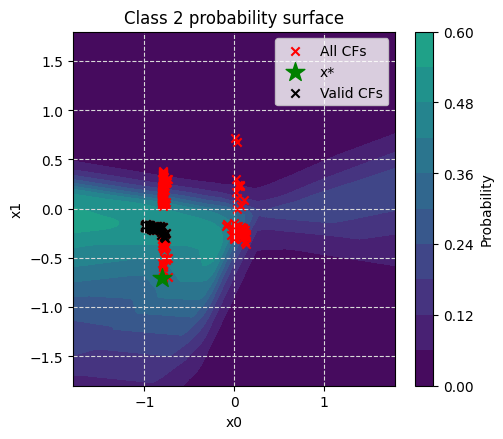

In [28]:

# With prob-based validity, use threshold instead of ==0.
# valid_mask = F_mmo[:, 0] < 0.05  # e.g. at least 95% target prob
# valid_F = F_mmo[valid_mask]
# valid_X = X_mmo[valid_mask]

# plt.figure()
# plt.scatter(X[:, 0], X[:, 1], c=Y, label="Original data", s=15, cmap="coolwarm")
# plt.scatter(X_mmo[:, 0], X_mmo[:, 1], c="red", marker="x", label="All CFs")
# plt.scatter(valid_X[:, 0], valid_X[:, 1], c="black", marker="x", label="Valid CFs")
# plt.scatter(x_star[0].item(), x_star[1].item(),
#             c="green", marker="*", s=200, label="x*")
# plt.legend()
# plt.show()


fig,ax=plot_proba(model, X,levels=10, class_of_interest=2)
ax.scatter(X_mmo[:, 0], X_mmo[:, 1], c="red", marker="x", label="All CFs")
ax.scatter(x_star[0].item(), x_star[1].item(),
           c="green", marker="*", s=200, label="x*")
# scatter valid CFs if any
if valided_X_mmo.shape[0] > 0:
    ax.scatter(valided_X_mmo[:, 0], valided_X_mmo[:, 1],
               c="black", marker="x", label="Valid CFs")

ax.legend()
plt.show()

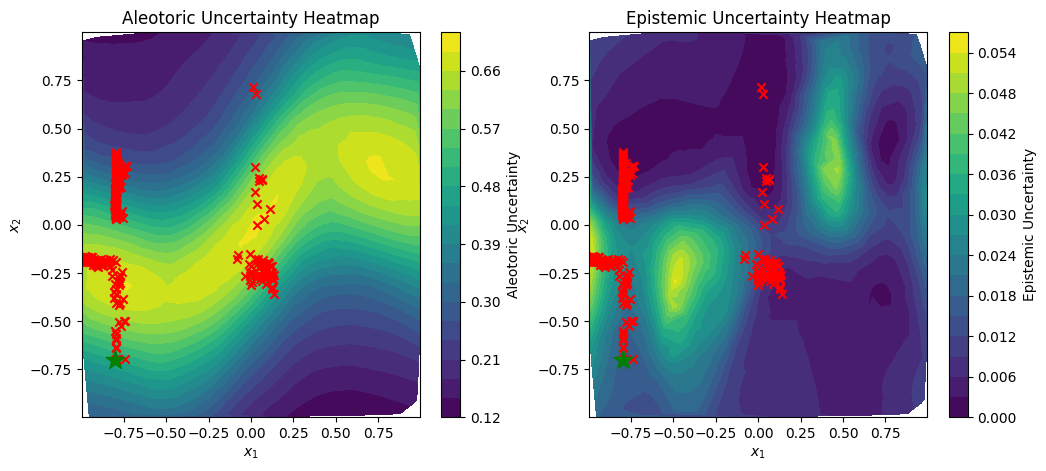

In [29]:
# draw AU heatmap with valid CFs
# AU= Aleotoric_Uncertainty_prob(moon_focus_prob)
AU=[-problem.objs[3](x) for x in X]
EU=[problem.objs[1](x) for x in X]

# plt.figure(figsize=(6.5, 5.5))
# plt.tricontourf(X[:, 0], X[:, 1], [problem.objs[1](x) for x in X], levels=5, cmap="viridis")
# plt.scatter(X_mmo[:, 0], X_mmo[:, 1], c="red", marker="x", label="All CFs")
# plt.colorbar(label=r"Aleotoric Uncertainty")
# plt.title("Aleotoric Uncertainty Heatmap")
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")
# plt.legend()
# plt.show()

fig,ax=plt.subplots(1,2,figsize=(12,5))
cntr1 = ax[0].tricontourf(X[:, 0], X[:, 1], AU, levels=20, cmap="viridis")
ax[0].scatter(X_mmo[:, 0], X_mmo[:, 1], c="red", marker="x", label="All CFs")
ax[0].scatter(x_star[0].item(), x_star[1].item(),
              c="green", marker="*", s=200, label="x*")
ax[0].set_title("Aleotoric Uncertainty Heatmap")
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
fig.colorbar(cntr1, ax=ax[0], label=r"Aleotoric Uncertainty")

cntr2 = ax[1].tricontourf(X[:, 0], X[:, 1], EU, levels=20, cmap="viridis")
ax[1].scatter(X_mmo[:, 0], X_mmo[:, 1], c="red", marker="x", label="All CFs")
ax[1].scatter(x_star[0].item(), x_star[1].item(),
              c="green", marker="*", s=200, label="x*")
ax[1].set_title("Epistemic Uncertainty Heatmap")
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")
fig.colorbar(cntr2, ax=ax[1], label=r"Epistemic Uncertainty")
plt.show()

In [30]:
poi=np.array([-1,-1])

# calc the TU again manually
prob0=0
prob1=0
for m in models:
    x_t = torch.from_numpy(poi.astype(np.float32)).unsqueeze(0).to(device)
    with torch.no_grad():
        probs = nn.Softmax(dim=1)(m(x_t)).cpu().numpy()
    prob1 += probs[0, 1]
    prob0 += probs[0, 0]
prob1=prob1/len(models)
prob0=prob0/len(models)
tu = -np.sum(np.array([prob0, prob1]) * np.log(np.array([prob0, prob1]) + 1e-12))


# calc the AU again manually
au=0
for m in models:
    x_t = torch.from_numpy(poi.astype(np.float32)).unsqueeze(0).to(device)
    with torch.no_grad():
        probs = nn.Softmax(dim=1)(m(x_t)).cpu().numpy()
    p1 = probs[0, 1]
    p0 = probs[0, 0]
    au+=-np.sum(np.array([p0, p1]) * np.log(np.array([p0, p1]) + 1e-12))
au=au/len(models)
tu,au,tu - au

(np.float32(0.31383896), np.float32(0.29375672), np.float32(0.020082235))

In [31]:
poi=np.array([4,2.6676])
problem.objs[1](poi), x_star

(np.float32(0.024556048), tensor([-0.8000, -0.7000]))

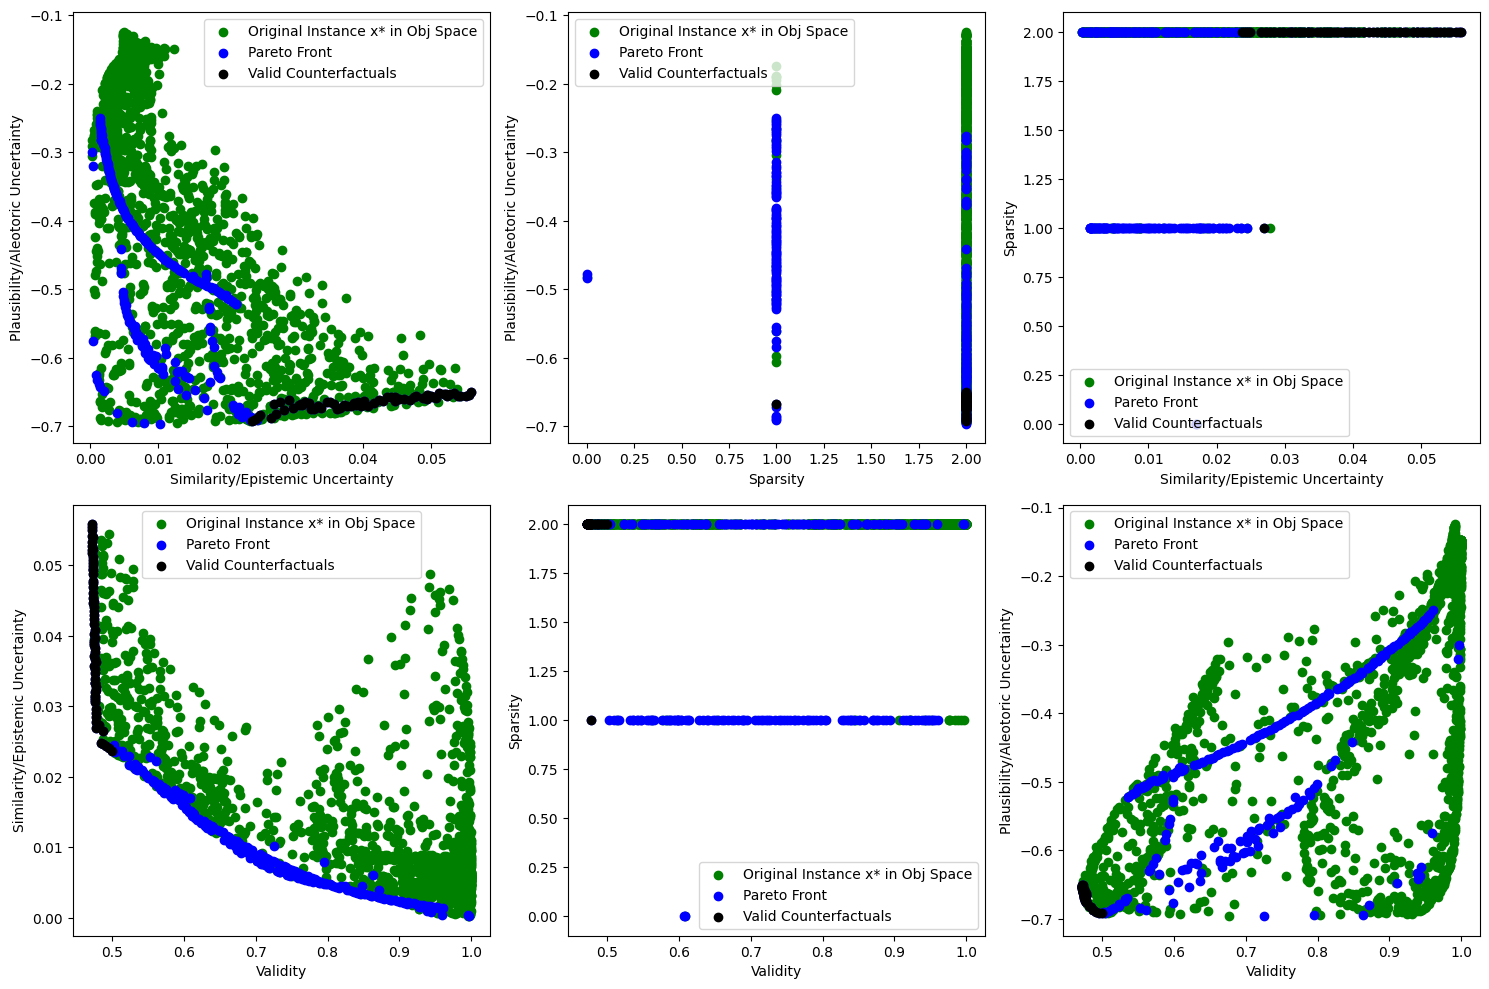

In [32]:

# visualize the Pareto front in objective space
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Create pairs of objective indices to plot
obj_pairs = [(1, 3), (2, 3), (1, 2), (0, 1), (0, 2), (0, 3)]
obj_labels = ['Validity', 'Similarity/Epistemic Uncertainty', 'Sparsity', 'Plausibility/Aleotoric Uncertainty']

for i, (obj_x, obj_y) in enumerate(obj_pairs):
    row = i // 3
    col = i % 3
    ax[row, col].scatter(problem.evaluate(X)[:, obj_x],
                         problem.evaluate(X)[:, obj_y],
                         c='green', label='Original Instance x* in Obj Space')
    ax[row, col].scatter(F_mmo[:, obj_x], F_mmo[:, obj_y], c='blue', label='Pareto Front')
    ax[row, col].scatter(valided_F_mmo[:, obj_x], valided_F_mmo[:, obj_y], c='black', label='Valid Counterfactuals')
    ax[row, col].set_xlabel(obj_labels[obj_x])
    ax[row, col].set_ylabel(obj_labels[obj_y])
    ax[row, col].legend()

plt.tight_layout()
plt.show()


In [33]:
import plotly.graph_objects as go

F_X = problem.evaluate(X)

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=problem.evaluate(X)[:,1], y=problem.evaluate(X)[:,0], z=-problem.evaluate(X)[:,3],
    mode='markers',
    marker=dict(color='green', size=3, opacity=0.2),
    name='Original observations in Obj Space'
))

fig.add_trace(go.Scatter3d(
    x=not_valided_F_mmo[:,1], y=not_valided_F_mmo[:,0], z=-not_valided_F_mmo[:,3],
    mode='markers',
    marker=dict(color='blue', size=
                5, opacity=1,symbol='cross'),
    name='Pareto Front which not valid'
))

fig.add_trace(go.Scatter3d(
    x=valided_F_mmo[:,1], y=valided_F_mmo[:,0], z=-valided_F_mmo[:,3],
    mode='markers',
    marker=dict(color='red', size=5, symbol='cross'),
    name='Valid Counterfactuals in Obj Space'
))


# add the fixed x_star point
fig.add_trace(go.Scatter3d(
    x=[problem.evaluate(x_star.detach().cpu().numpy().astype(np.float32))[1]],
    y=[problem.evaluate(x_star.detach().cpu().numpy().astype(np.float32))[0]],
    z=[-problem.evaluate(x_star.detach().cpu().numpy().astype(np.float32))[3]],
    mode='markers',
    marker=dict(color='purple', size=6),
    name='Factual Instance x* in Obj Space'
))

fig.update_layout(
    scene=dict(
        xaxis_title='similarity/epistemic uncertainty',
        yaxis_title='prob-based validity',
        zaxis_title='plausibility/aleotoric uncertainty'
    ),
    width=900, height=700
)

# reverse z axis
fig.update_layout(scene=dict(zaxis=dict(autorange='reversed')))

fig.show()

# save to html
fig.write_html("pareto_front_3d.html")


In [34]:
F_mmo.shape

(280, 4)